## Objective

The data contains 8 lakh rows of sessions on UC customer app from Dec 17,2018 to Jan 30,2019. These are the sessions landed on the UC slots page. (This is the page where customers select booking time preference)

The Goal of this project is to build a model using 3 weeks of historical data (Dec 17 to Jan 13) to predict what is the probability a given session resulting in a request.. 

Let's first start to investigate if indeed 1.category 2.day_of_week 3.no_of_slots decides conversion from slot page to request page 

In [1]:
##Package import 
import pandas as pd
%matplotlib inline 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
from pdpbox import pdp, info_plots 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
data = pd.read_csv("uc-assignment-slots.csv")
data.head()

,record_id,city_key,event_time,weekday,category_key,rptcatg,req_id,session_group
0,5c1699b0c3658c25008e1192,city_chennai_v2,2018-12-17 00:00:08,weekday,professional_bathroom_cleaning,Cleaning - Other,5c1699d714bd522300fae954,3022
1,5c1699b72dd2b92500f5f400,city_mumbai_v2,2018-12-17 00:00:15,weekday,electricians,EPC,5c1699ed70fa4f2500d66e7c,3303
2,5c1699df4fb96a2400166132,city_mumbai_v2,2018-12-17 00:00:55,weekday,salon_at_home,Salon at Home,NaN,3330
3,5c1699f405cbce26002ff832,city_kolkata_v2,2018-12-17 00:01:16,weekday,salon_at_home,Salon at Home,NaN,3330
4,5c1699fb02f88224006901f5,city_chennai_v2,2018-12-17 00:01:23,weekday,plumbers,EPC,5c169a6c8c954c2200693538,3303


## Basic Feature Engineering And Label Creation

In [2]:
#data = data[(data["rptcatg"] =="Salon at Home") | (data["rptcatg"] =="EPC")]
#data = data[(data["rptcatg"] =="Salon at Home")]
data["event_time"] = pd.to_datetime(data["event_time"])
data['SessionID'] = (data.event_time-data.event_time.shift(1) > pd.Timedelta(6, 'h')).cumsum()+1
data['SessionID'] = data['SessionID']%24
def man_woman(x):
    if "Men" in x.split(" "):
        return "Men"
    if "Women" in x.split(" "):
        return "Women"
    else:
        return "Not Sure"
data['Gender'] = data['rptcatg'].apply(man_woman)

data['Label'] = list(map(lambda x: 1 if type(x)==str else 0 ,data['req_id']))
data["hour_numeric"] = data["event_time"].dt.hour.astype(int)
data["hour_object"] = data["event_time"].dt.hour.astype(object)
data["day"] = data["event_time"].dt.day_name()


p = ['p0','p1','p2','p3']
for idx, val in enumerate(p):
    #print(idx, val)
    data[val] = data["session_group"].astype(str).str[idx]
    data[val+"_"+"object"] = data["session_group"].astype(str).str[idx]
    #print(data[val])
    data[val+"_numeric"] = pd.to_numeric(data[val], errors='coerce').fillna(method ="backfill")
data.drop(p+["session_group"],axis=1,inplace=True)
data.fillna(method ="bfill",inplace=True)
data.fillna(0,inplace=True)
data["hour_day_category"] = data["SessionID"].map(str) + data["day"].map(str)
#data["hour_category"] = data["hour_numeric"].map(str)  + data["category_key"].map(str)
print(data.shape)
print data.dtypes
data.head()

columns_to_drop = ["record_id","req_id"]
#X = pd.get_dummies(data[["city_key","weekday","category_key","hour","day",'p0','p1','p2','p3']])
data_ = data.copy()
data_ = data_.drop(columns_to_drop,axis=1)
list_numeric = [col for col in data.columns if "_numeric" in col]
list_numeric.remove("hour_numeric")
data_["Total_Available_slot_numeric"] = data["p1_numeric"]+data["p2_numeric"]+data["p2_numeric"]
data_["p0_minus_p1_numeric"] = data["p0_numeric"]-data["p1_numeric"]

for ele in list_numeric:
    zz = data_.groupby(["SessionID","rptcatg"],as_index=False).agg({ele:{"max_"+"_"+str(ele):np.max,"min_"+"_"+str(ele):np.min,"std_"+"_"+str(ele):np.std}})
    zz.columns = ["SessionID","rptcatg","std_"+"_"+str(ele),"min_"+"_"+str(ele),"max_"+"_"+str(ele)]
    #(gb+"_"+str(ele)).columns = ["category_key","rptcatg","std_hour","min_hour","max_hour"]
    data_ = pd.merge(data_,zz,how="left", on= ["SessionID","rptcatg"])
data_.head()

(816530, 22)
record_id                    object
city_key                     object
event_time           datetime64[ns]
weekday                      object
category_key                 object
rptcatg                      object
req_id                       object
SessionID                     int64
Gender                       object
Label                         int64
hour_numeric                  int64
hour_object                   int64
day                          object
p0_object                    object
p0_numeric                    int64
p1_object                    object
p1_numeric                  float64
p2_object                    object
p2_numeric                  float64
p3_object                    object
p3_numeric                  float64
hour_day_category            object
dtype: object


,city_key,event_time,weekday,category_key,rptcatg,SessionID,Gender,Label,hour_numeric,hour_object,...,max__p0_numeric,std__p1_numeric,min__p1_numeric,max__p1_numeric,std__p2_numeric,min__p2_numeric,max__p2_numeric,std__p3_numeric,min__p3_numeric,max__p3_numeric
0,city_chennai_v2,2018-12-17 00:00:08,weekday,professional_bathroom_cleaning,Cleaning - Other,1,Not Sure,1,0,0,...,0.697302,1.137875,0.0,3.0,3.0,0.0,0.814267,0.422538,3.0,0.0
1,city_mumbai_v2,2018-12-17 00:00:15,weekday,electricians,EPC,1,Not Sure,1,0,0,...,0.693610,0.873354,0.0,3.0,3.0,0.0,0.352993,0.241362,3.0,0.0
2,city_mumbai_v2,2018-12-17 00:00:55,weekday,salon_at_home,Salon at Home,1,Not Sure,0,0,0,...,0.702878,1.100545,0.0,3.0,3.0,0.0,0.643995,0.411650,3.0,0.0
3,city_kolkata_v2,2018-12-17 00:01:16,weekday,salon_at_home,Salon at Home,1,Not Sure,0,0,0,...,0.702878,1.100545,0.0,3.0,3.0,0.0,0.643995,0.411650,3.0,0.0
4,city_chennai_v2,2018-12-17 00:01:23,weekday,plumbers,EPC,1,Not Sure,1,0,0,...,0.693610,0.873354,0.0,3.0,3.0,0.0,0.352993,0.241362,3.0,0.0


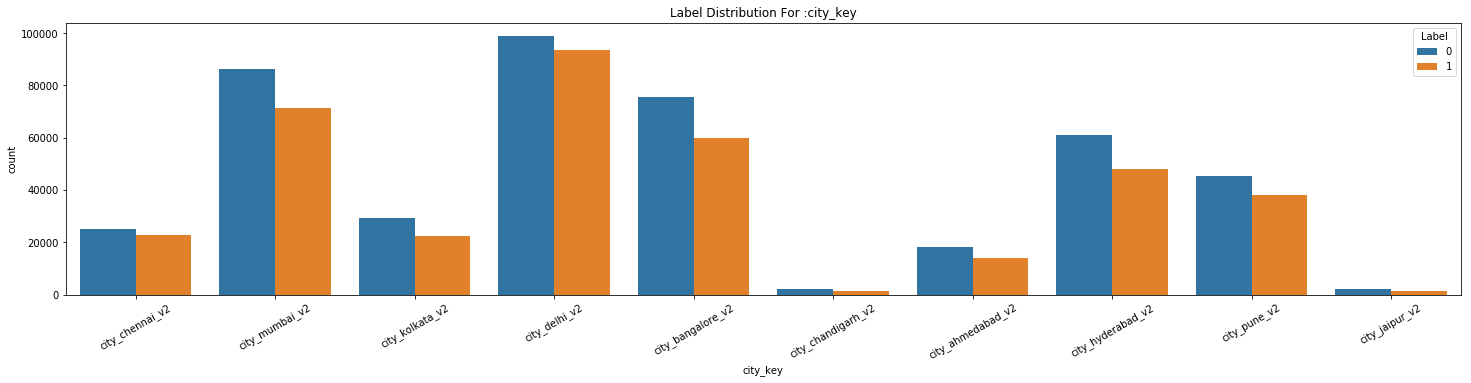

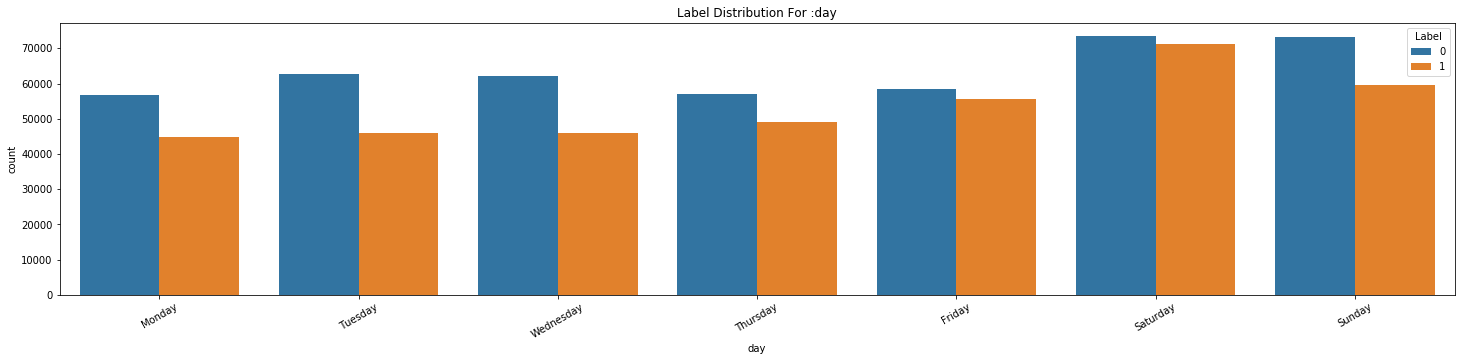

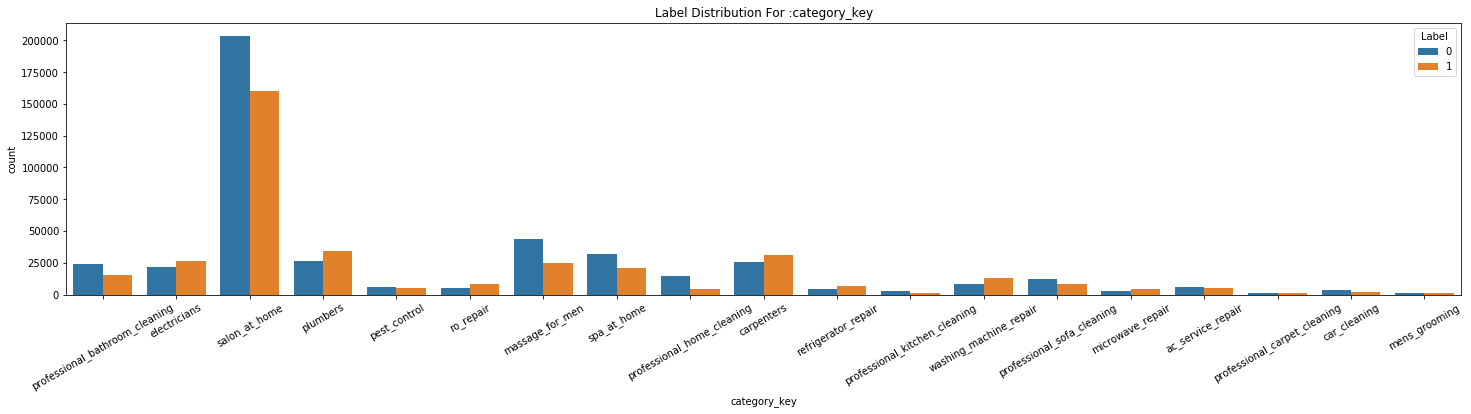

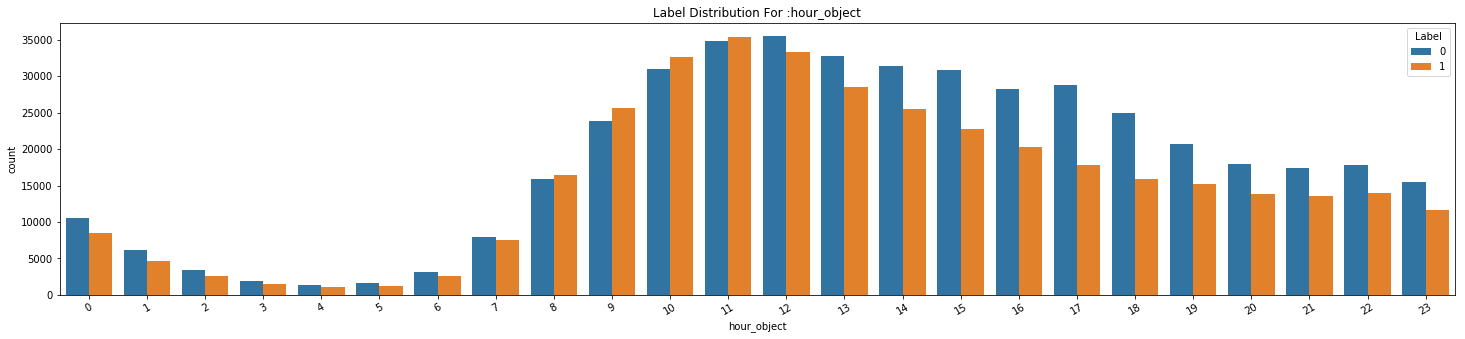

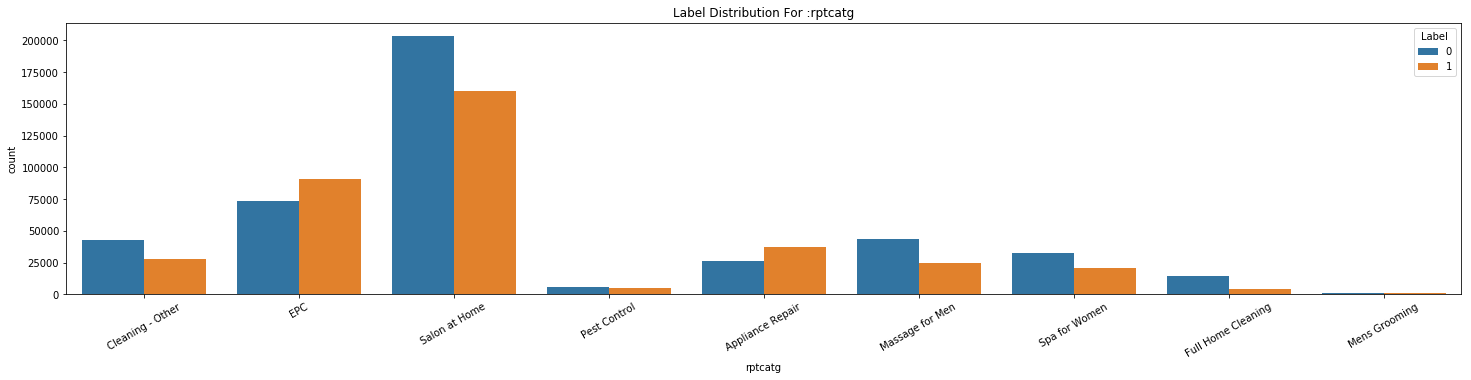

In [4]:
for col in ["city_key", "day","category_key","hour_object","rptcatg"]:
    plt.figure(figsize=(25,5))
    g = sns.countplot(x=col, hue="Label", data=data_)
    g.set_xticklabels(g.get_xticklabels(),rotation=30);
    plt.title("Label Distribution For :" + str(col))
    plt.show()
    
data_.drop("hour_object",axis=1,inplace=True)

## Partial Dependence Plots

People complain machine learning models are black boxes. These people will argue we cannot see how these models are working on any given dataset, so we can neither extract insight nor identify problems with the model.

this is where Partial dependence plots comes to the rescue. It shows how each variable or predictor affects the model's predictions. 
This is useful for questions like:
1. How much of wage differences between men and women are due solely to gender, as opposed to differences in education backgrounds or work experience?

2. Controlling for house characteristics, what impact do longitude and latitude have on home prices? To restate this, we want to understand how similarly sized houses would be priced in different areas, even if the homes actually at these sites are different sizes.

3. Are health differences between two groups due to differences in their diets, or due to other factors?

Partial dependence plots can be interepreted similarly to the coefficients in linear or logistic regression models. But partial dependence plots can capture more complex patterns from your data, and they can be used with any model.

For Partial Dependence plot we Label Encode our features and fit a Gradient Boosting classifier and then plot Partial Dependence Plot 

In [5]:
##LAbel Encode
date_col = "event_time"
columns_to_drop = [date_col]
#X = pd.get_dummies(data[["city_key","weekday","category_key","hour","day",'p0','p1','p2','p3']])
#data_ = data_filtered.copy()
data_categorical = data_.drop(columns_to_drop,axis=1).select_dtypes(exclude=["int64","float64"])
data_numerical = data_.drop(columns_to_drop,axis=1).select_dtypes(include=["int64","float64"])
data_categorical = data_categorical.apply(LabelEncoder().fit_transform)
transformed_data = pd.concat([data_categorical,data_numerical], axis=1)
transformed_data = pd.concat([transformed_data,data_[date_col]], axis=1)
data_train = transformed_data[transformed_data[date_col] <"2019-01-14 00:00:00"]
data_test = transformed_data[transformed_data[date_col] >"2019-01-14 00:00:00"]
data_train.drop(date_col, axis=1,inplace=True)
data_test.drop(date_col, axis=1,inplace=True)
print(data_train.shape, data_test.shape)

X_train_label = data_train.drop("Label",axis=1)
y_train_label = data_train["Label"]
X_test_label = data_test.drop("Label",axis=1)
y_test_label = data_test["Label"]
#print X_test_label.columns

((644448, 32), (172082, 32))


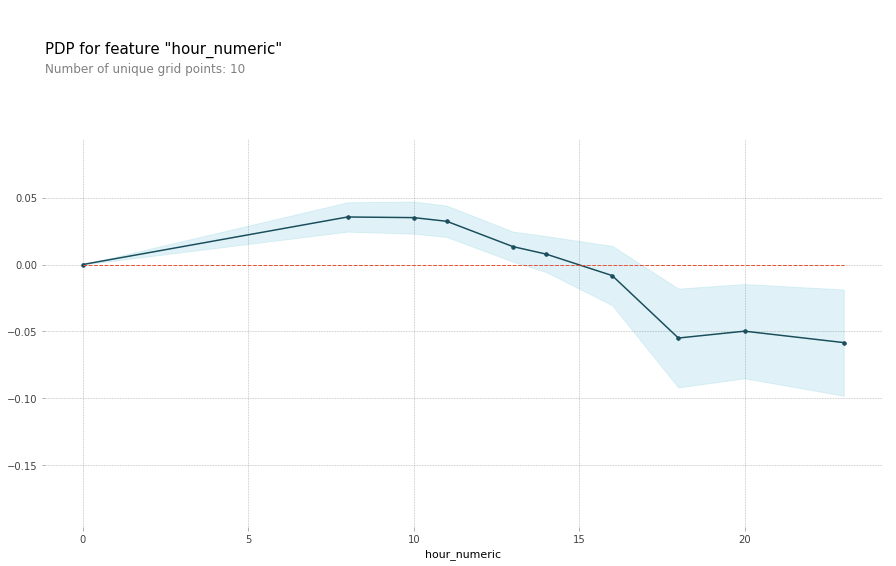

In [6]:
my_model = GradientBoostingClassifier()
# fit the model as usual
my_model.fit(X_train_label, y_train_label)

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=my_model, dataset=X_train_label, model_features=X_train_label.columns, feature='hour_numeric')

# plot it
pdp.pdp_plot(pdp_goals, 'hour_numeric')
plt.show()

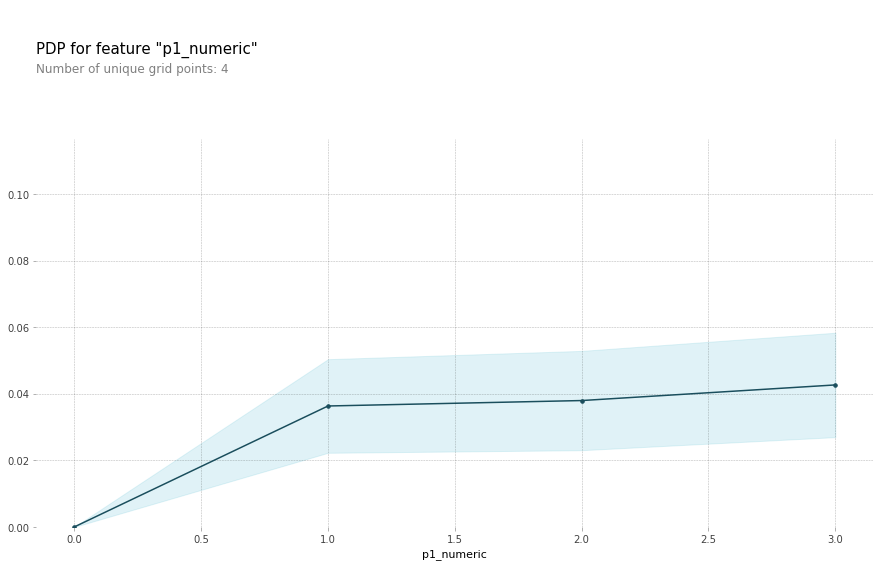

In [7]:
pdp_goals = pdp.pdp_isolate(model=my_model, dataset=X_train_label, model_features=X_train_label.columns, feature='p1_numeric')

# plot it
pdp.pdp_plot(pdp_goals, 'p1_numeric')
plt.show()

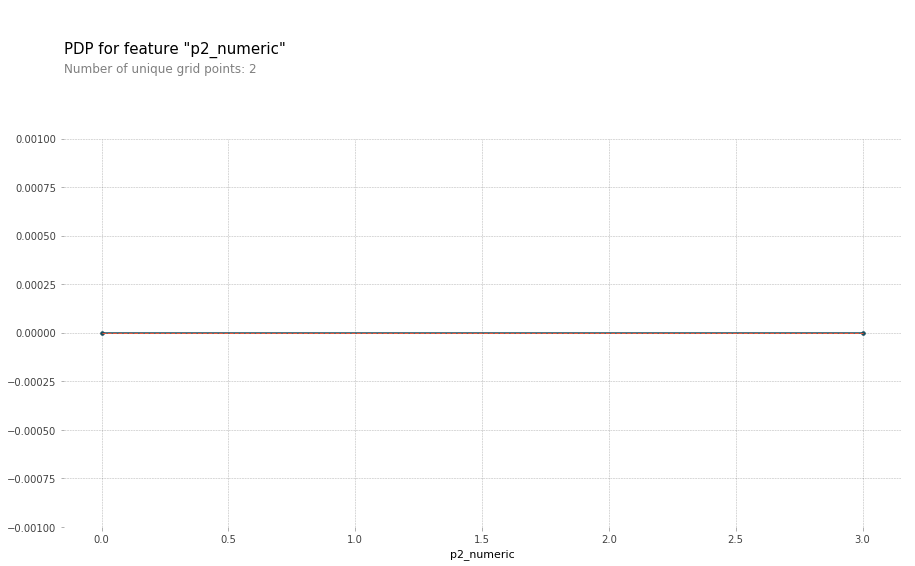

In [8]:
pdp_goals = pdp.pdp_isolate(model=my_model, dataset=X_train_label, model_features=X_train_label.columns, feature='p2_numeric')

# plot it
pdp.pdp_plot(pdp_goals, 'p2_numeric')
plt.show()

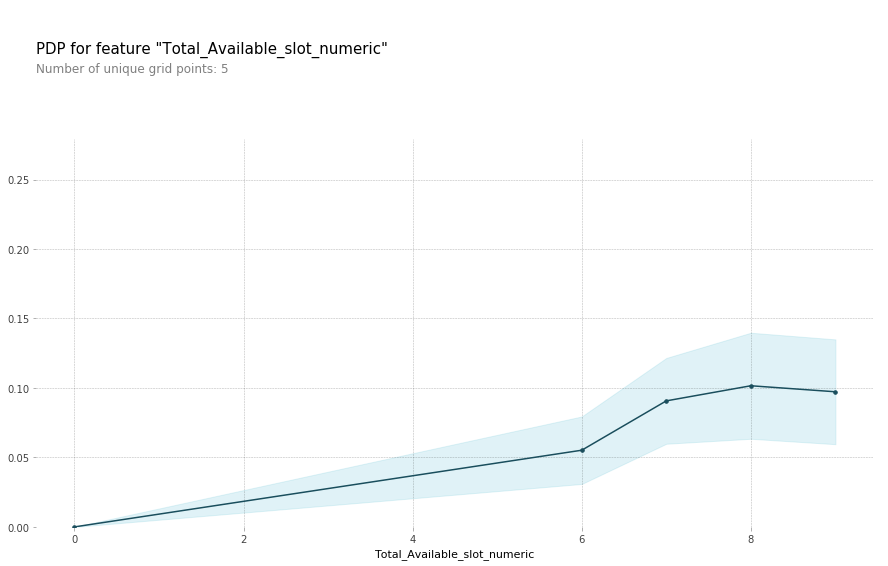

In [9]:
pdp_goals = pdp.pdp_isolate(model=my_model, dataset=X_train_label, model_features=X_train_label.columns, feature='Total_Available_slot_numeric')

# plot it
pdp.pdp_plot(pdp_goals, 'Total_Available_slot_numeric')
plt.show()

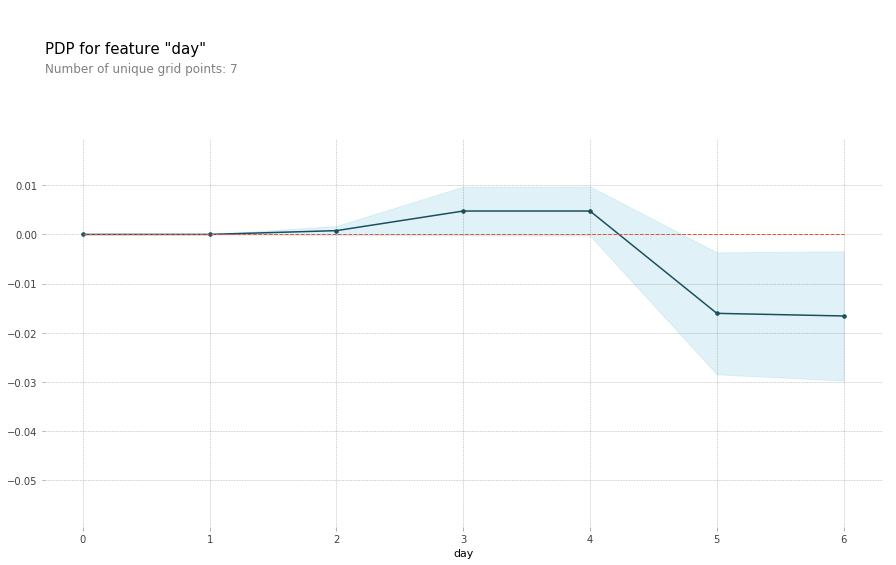

In [10]:
pdp_goals = pdp.pdp_isolate(model=my_model, dataset=X_train_label, model_features=X_train_label.columns, feature='day')

# plot it
pdp.pdp_plot(pdp_goals, 'day')
plt.show()

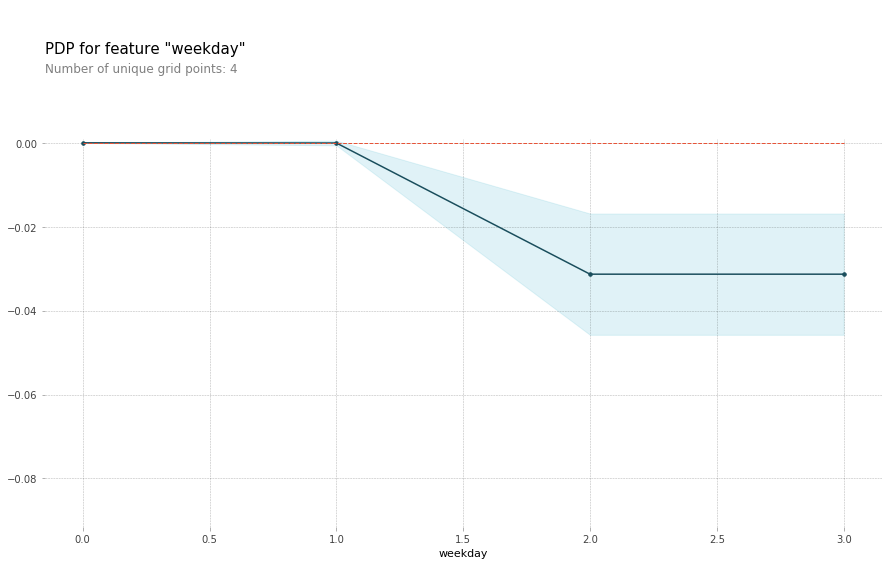

In [11]:
pdp_goals = pdp.pdp_isolate(model=my_model, dataset=X_train_label, model_features=X_train_label.columns, feature='weekday')

# plot it
pdp.pdp_plot(pdp_goals, 'weekday')
plt.show()

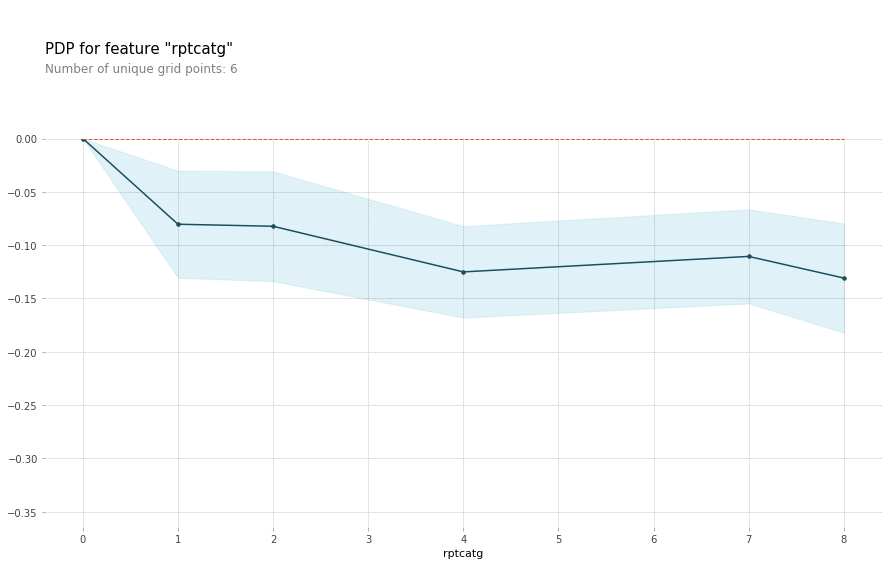

In [12]:


pdp_goals = pdp.pdp_isolate(model=my_model, dataset=X_train_label, model_features=X_train_label.columns, feature='rptcatg')

# plot it
pdp.pdp_plot(pdp_goals, 'rptcatg')
plt.show()

In [13]:
# pdp_goals = pdp.pdp_isolate(model=my_model, dataset=X_train_label, model_features=X_train_label.columns, feature="max__p0_minus_p1_power_numeric")

# # plot it
# pdp.pdp_plot(pdp_goals, "max__p0_minus_p1_power_numeric")
# plt.show()

In [14]:
# inter1  =  pdp.pdp_interact(model=my_model, dataset=X_train_label, model_features=X_train_label.columns, features=['Total_Available_slot_numeric', 'hour_numeric'])

# pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['Total_Available_slot_numeric', 'hour_numeric'], plot_type='contour')
# plt.show()

## PCA for Visualisation 

(644448, 31)
(644448, 2)


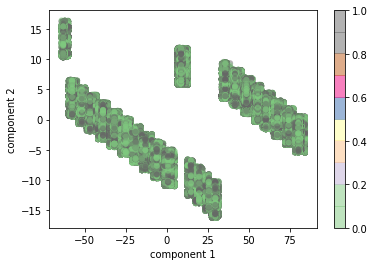

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
projected = pca.fit_transform(X_train_label)
print(X_train_label.shape)
print(projected.shape)
projected_test = pca.transform(X_test_label)
projected_test.shape
plt.scatter(projected[:, 0], projected[:, 1],c=y_train_label, edgecolor='none', alpha=0.5,cmap=plt.cm.get_cmap('Accent', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

## Model Fitting 

In [16]:
#One Hot Encoding
data__ = data_.copy()
data_ = pd.get_dummies(data__.drop(["Label","event_time"],axis=1))
data_ = pd.concat([data_,data__[["Label","event_time"]]],axis=1)
data_train = data_[data_["event_time"] <"2019-01-14 00:00:00"]
data_test = data_[data_["event_time"] >"2019-01-14 00:00:00"]
X_train = data_train.drop(["Label","event_time"],axis=1)
y_train = data_train["Label"]
X_test = data_test.drop(["Label","event_time"],axis=1)
y_test = data_test["Label"]
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(method ="bfill",inplace=True)
X_test.fillna(0,inplace=True)
X_train.shape,X_test.shape

((644448, 240), (172082, 240))

In [17]:
%%time
#clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=10, random_state=0)
clf = RandomForestClassifier(n_jobs=8, random_state=0,n_estimators=200,max_depth=5)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_train)[:,1]
#pd.DataFrame({"Label":y, "Pred": preds })
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, preds)
print "Train AUC",auc(false_positive_rate, true_positive_rate)
print "Accuracy", accuracy_score(y_train, clf.predict(X_train))
#
preds = clf.predict_proba(X_test)[:,1]
#pd.DataFrame({"Label":y, "Pred": preds })
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, preds)
print "Test AUC", auc(false_positive_rate, true_positive_rate)
print "Accuracy",accuracy_score(y_test, clf.predict(X_test))

Train AUC 0.6183527577197986
Accuracy 0.583912123243458
Test AUC 0.6017755771005254
Accuracy 0.5686184493439175
CPU times: user 2min 43s, sys: 9.4 s, total: 2min 52s
Wall time: 29.3 s


## Grid Search to find best hyperparameters for Random Forest

In [18]:
# Create the parameter grid based on the results of random search 
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,6,7,8],
    'max_features': [2,3,4],
    'min_samples_leaf': [3, 4,5,6],
    'min_samples_split': [8,9,10],
    'n_estimators': [20,40]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 2, n_jobs = -1, verbose = 2)
grid_search.fit(X_train_label, y_train_label)
grid_search.best_params_

In [19]:
%%time
#clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=10, random_state=0)
#clf = RandomForestClassifier(bootstrap= True, max_depth= 8,max_features= 4,min_samples_leaf= 4,min_samples_split= 9,n_estimators= 20)
clf = RandomForestClassifier(bootstrap= True, max_depth= 8,max_features= 4,min_samples_leaf= 4,min_samples_split= 9,n_estimators= 20)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_train)[:,1]
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, preds)
print "Train AUC",auc(false_positive_rate, true_positive_rate)
print "Accuracy", accuracy_score(y_train, clf.predict(X_train))



# clf.fit(X_train, y_train)
# preds = clf.predict_proba(X_train)[:,1]
# false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, preds)
# print "Train AUC",auc(false_positive_rate, true_positive_rate)
# print "Accuracy", accuracy_score(y_train, clf.predict(X_train))


#pd.DataFrame({"Label":y, "Pred": preds })
#
preds = clf.predict_proba(X_test)[:,1]
#pd.DataFrame({"Label":y, "Pred": preds })
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, preds)
print "Test AUC", auc(false_positive_rate, true_positive_rate)
print "Accuracy",accuracy_score(y_test, clf.predict(X_test))

Train AUC 0.6184422837999757
Accuracy 0.5822471324296142
Train AUC 0.6189509145083869
Accuracy 0.5806069690649983
Test AUC 0.6010745386133813
Accuracy 0.5619297776641369
CPU times: user 20.4 s, sys: 9.95 s, total: 30.4 s
Wall time: 30.4 s


## Confusion Matrix for Random Forest for differet Subcategories. 

('For rptcatg = ', 'Salon at Home')
Test AUC 0.5797117308063671


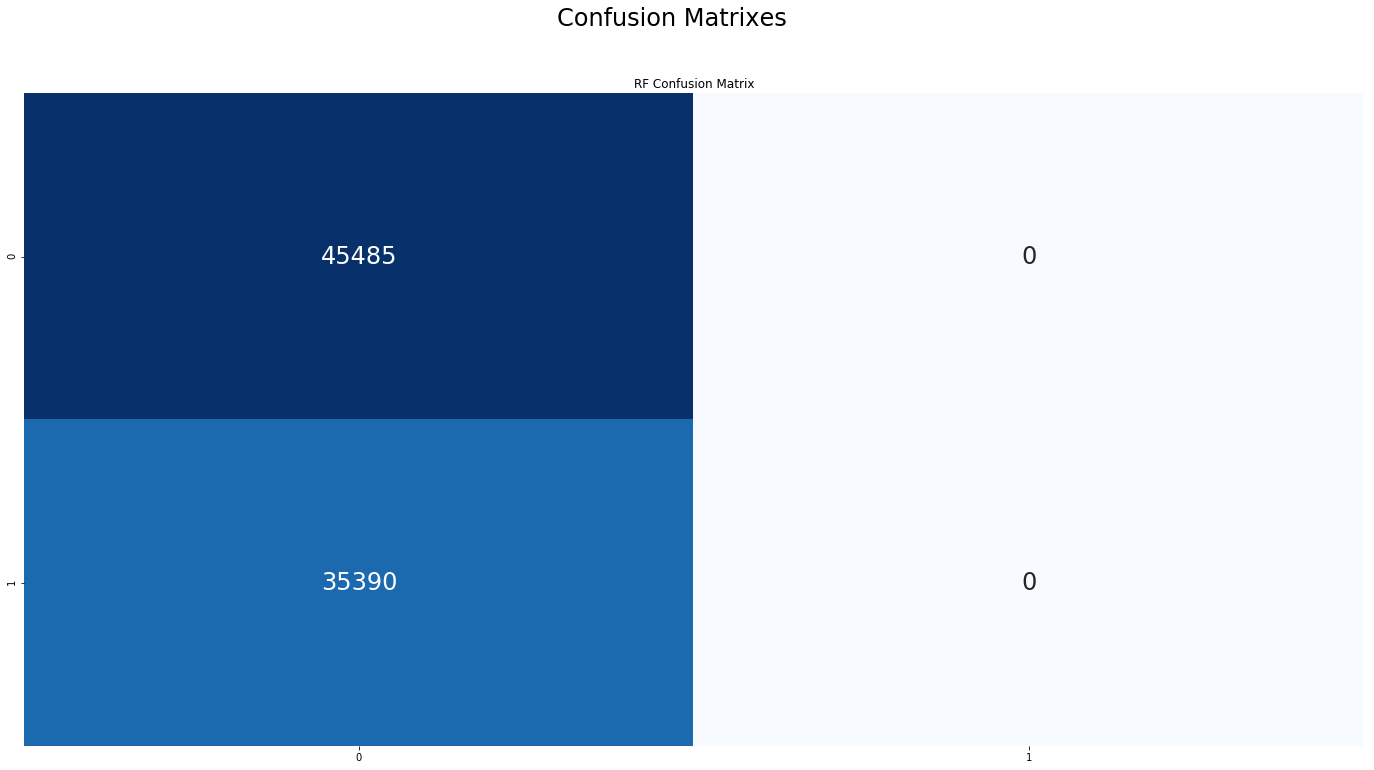

('For rptcatg = ', 'Appliance Repair')
Test AUC 0.5616837389756175


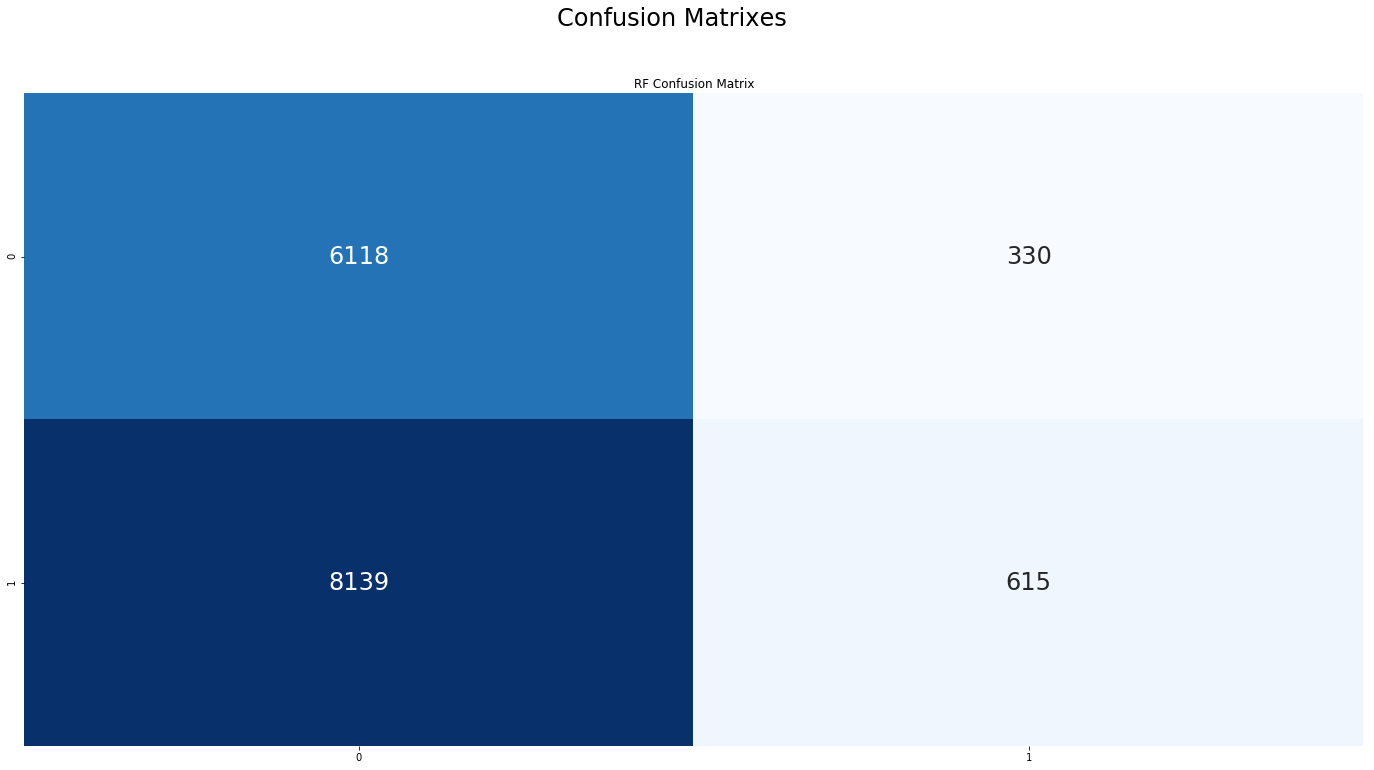

('For rptcatg = ', 'Cleaning - Other')
Test AUC 0.5680361101304685


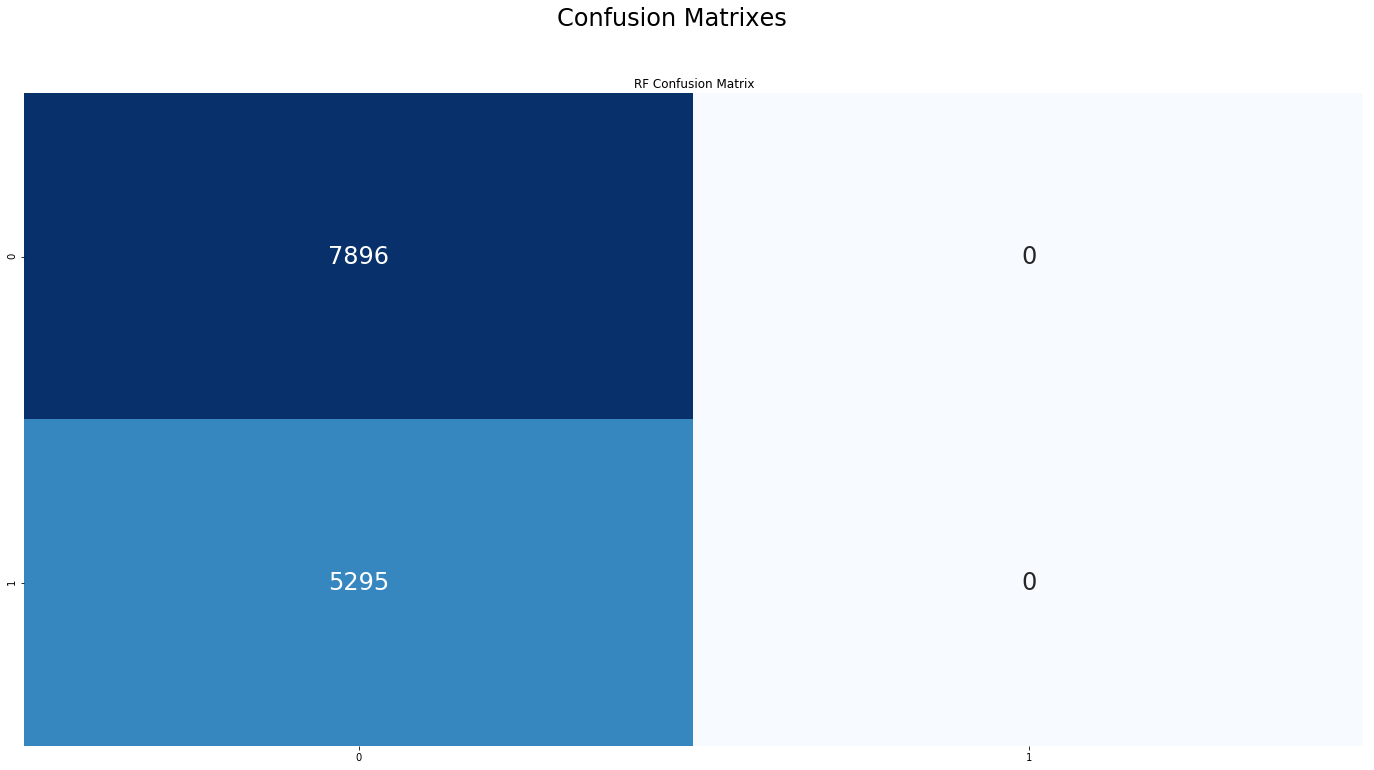

('For rptcatg = ', 'EPC')
Test AUC 0.5728849742949234


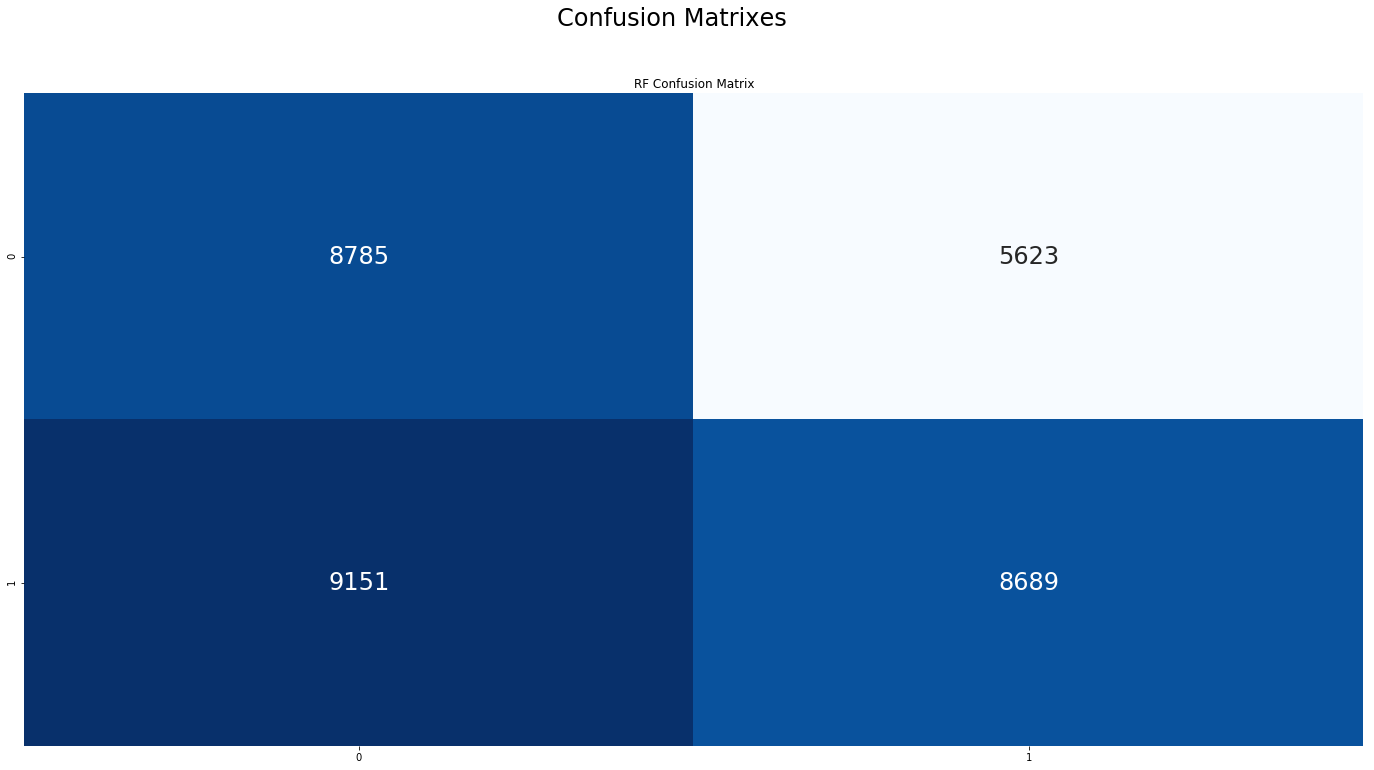

('For rptcatg = ', 'Spa for Women')
Test AUC 0.5978804246889123


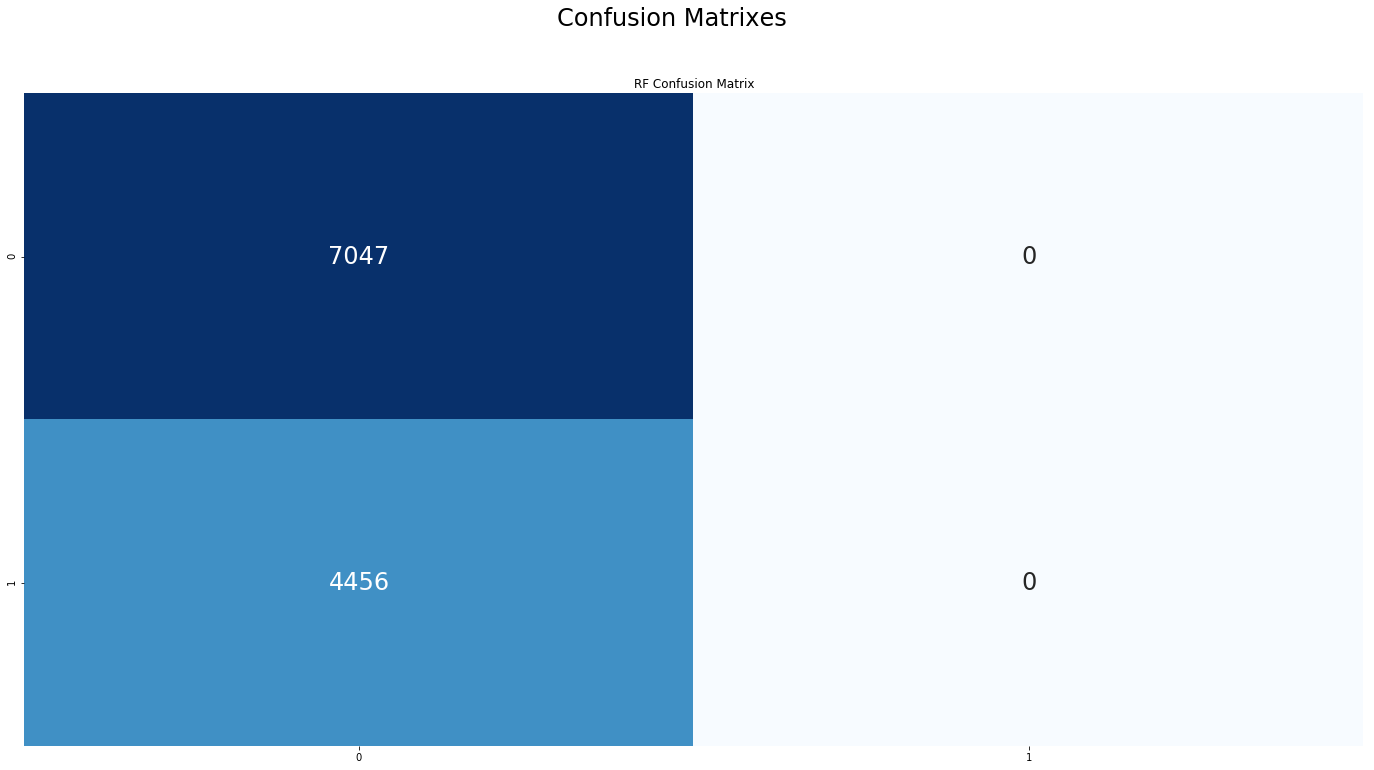

('For rptcatg = ', 'Full Home Cleaning')
Test AUC 0.5065843123006741


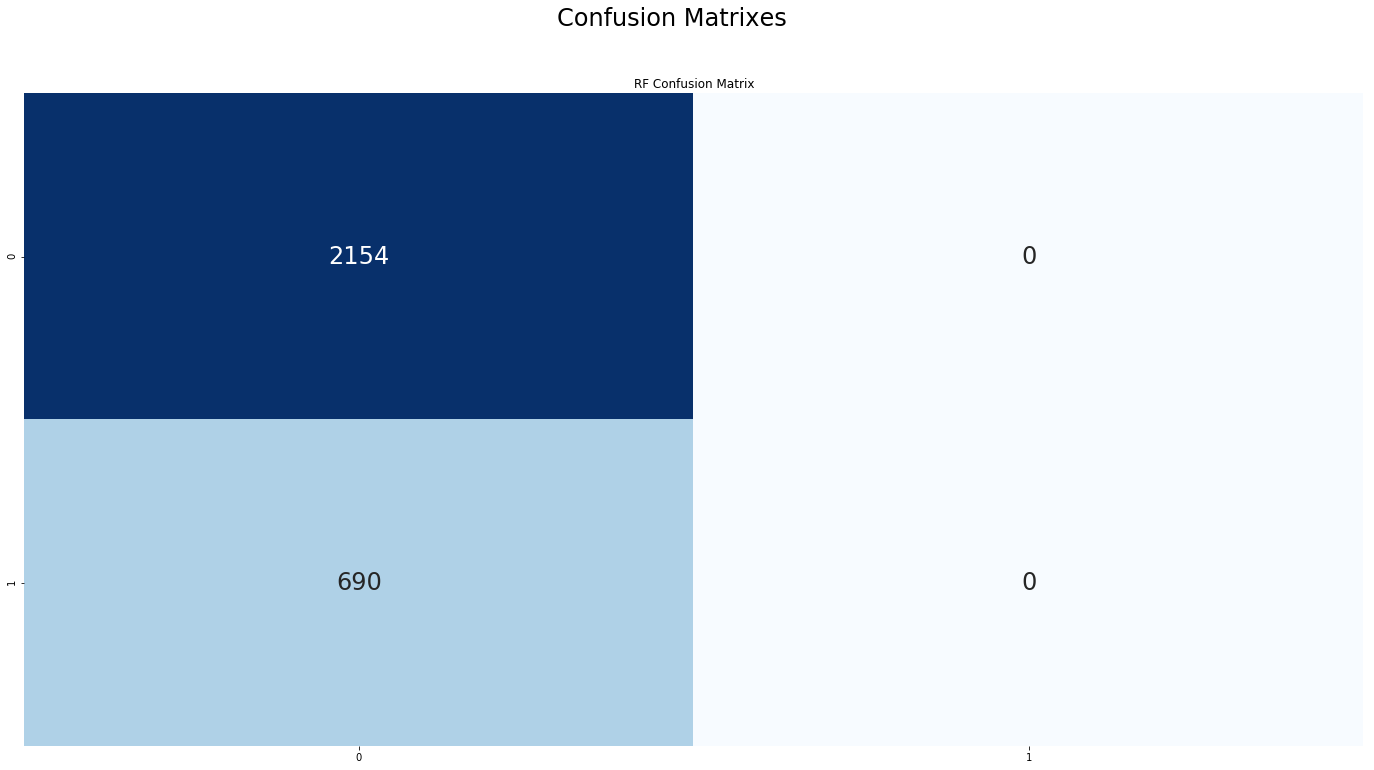

('For rptcatg = ', 'Massage for Men')
Test AUC 0.5694277300120625


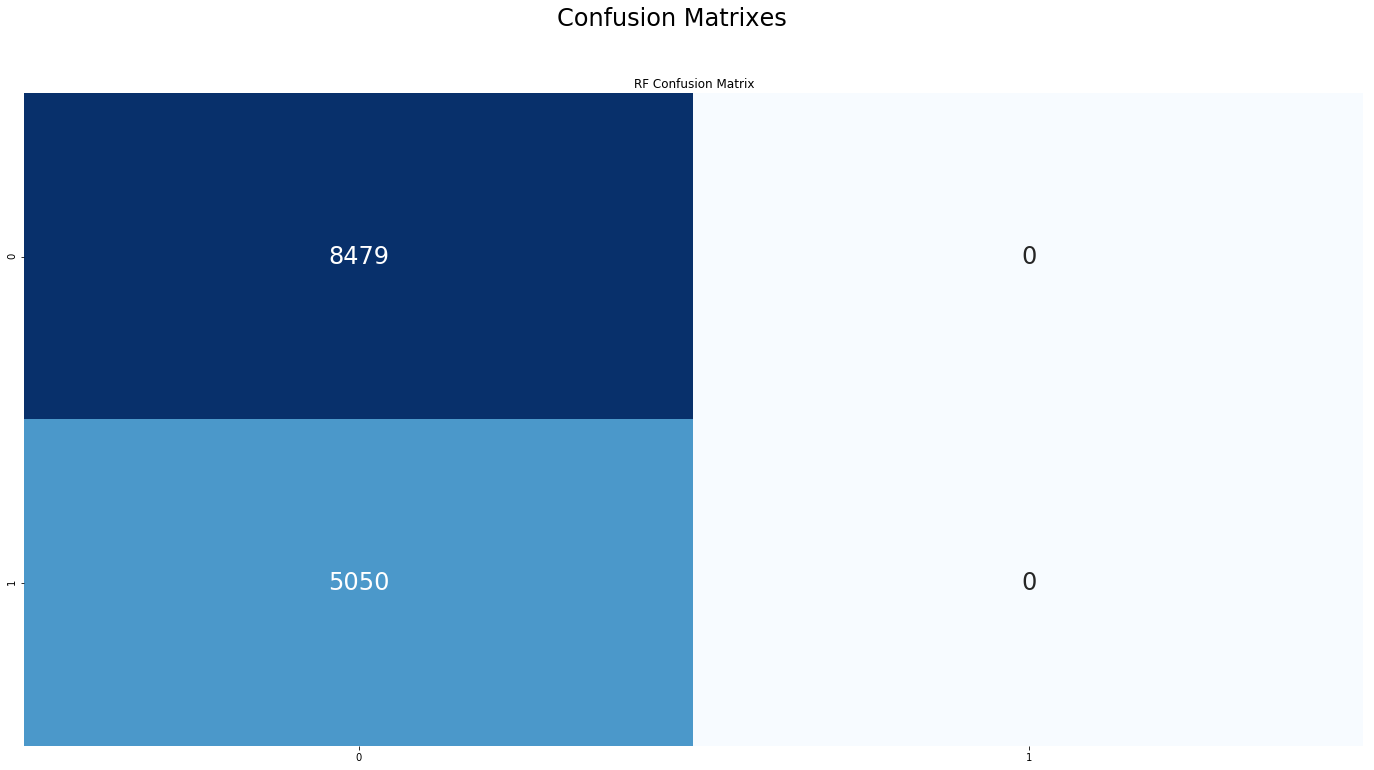

('For rptcatg = ', 'Mens Grooming')
Test AUC 0.5494791172508018


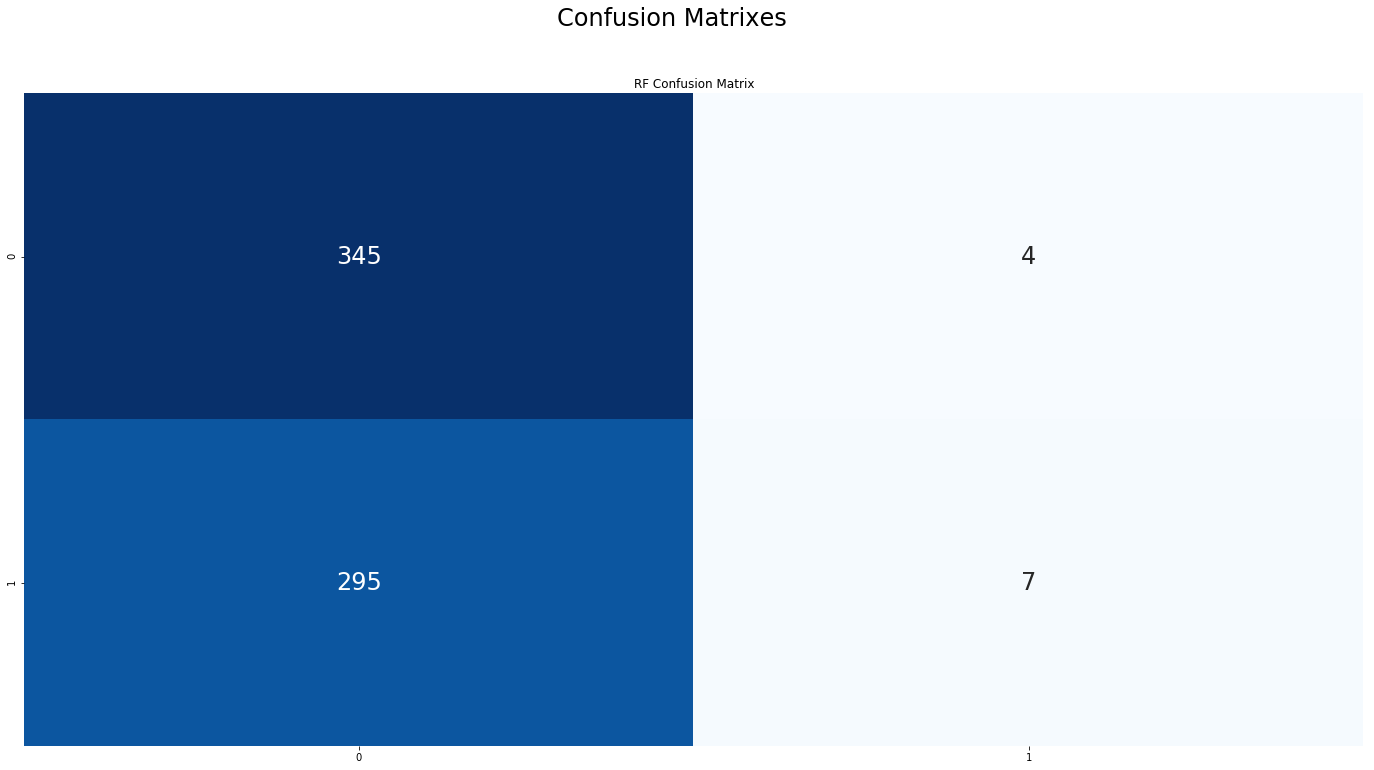

('For rptcatg = ', 'Pest Control')
Test AUC 0.546802573077287


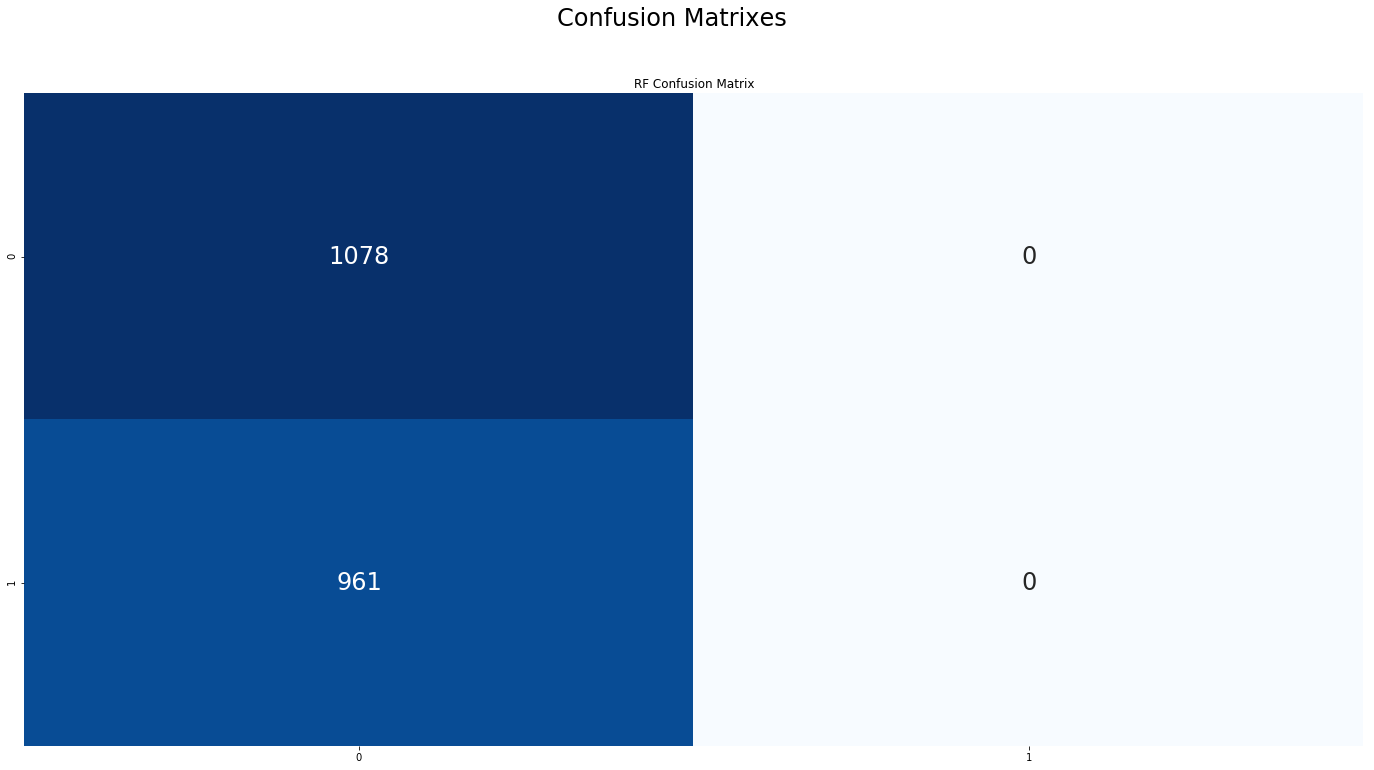

In [20]:
from sklearn.metrics import confusion_matrix
last = data__[data__["event_time"] >"2019-01-14 00:00:00"].copy()
last["finalpred"] = clf.predict(X_test)
last["finalpred_proba"] = clf.predict_proba(X_test)[:,1]
for ele in last['rptcatg'].unique():
    plt.figure(figsize=(24,12))
    plt.suptitle("Confusion Matrixes",fontsize=24)
    plt.subplots_adjust(wspace = 0.4, hspace= 0.4)
    cm_lr = confusion_matrix(last[last['rptcatg'] == ele]["Label"], last[last['rptcatg'] == ele]["finalpred"])
    plt.title("RF Confusion Matrix")
    print("For rptcatg = ", ele)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(last[last['rptcatg'] == ele]["Label"], last[last['rptcatg'] == ele]["finalpred_proba"])
    print "Test AUC",auc(false_positive_rate, true_positive_rate)
    #print "Accuracy", accuracy_score(y_train, clf.predict(X_train))

    sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
    plt.show()

<Figure size 432x288 with 0 Axes>

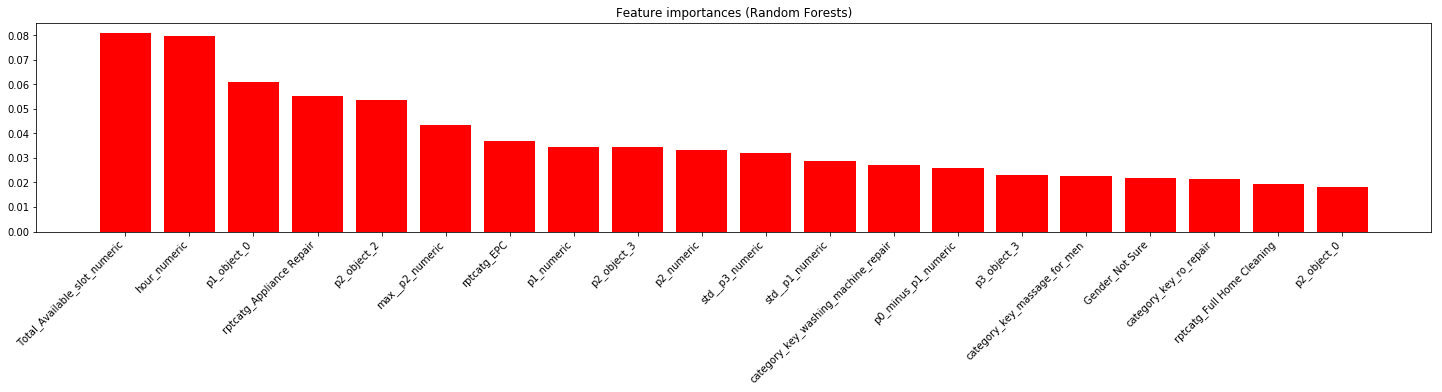

In [21]:
coefs = clf.feature_importances_
indices = np.argsort(coefs)[::-1]
yy = 20
plt.figure()
plt.figure(figsize=(25,5))
plt.title("Feature importances (Random Forests)")
plt.bar(range(yy), coefs[indices[:yy]],
       color="r", align="center")
plt.xticks(range(yy), X_train.columns[indices[:yy]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

plt.ion(); plt.show()

## Logistic Regression

In [22]:
import numpy as np
logisticRegr = LogisticRegression(C =1.0)
logisticRegr.fit(X_train, y_train)
preds_lr = logisticRegr.predict_proba(X_train)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, preds_lr[:,1])
print "Train AUC",auc(false_positive_rate, true_positive_rate)

preds_lr = logisticRegr.predict_proba(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, preds_lr[:,1])
print "Test AUC",auc(false_positive_rate, true_positive_rate)

Train AUC 0.6227759445154307
Test AUC 0.6059170226290769


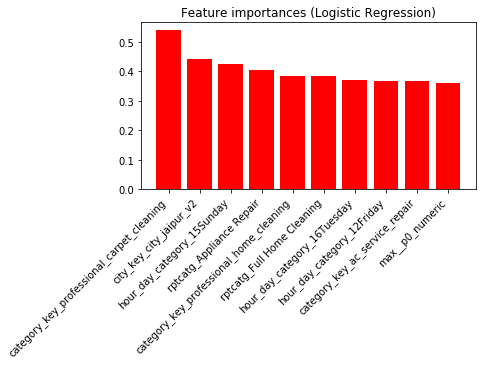

In [23]:
coefs = np.abs(logisticRegr.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(10), coefs[indices[:10]],
       color="r", align="center")
plt.xticks(range(10), X_train.columns[indices[:10]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)


## Confusion Matrix for Logistic Regression for differet Subcategories. 

Test AUC 0.5795150611057249
('For rptcatg = ', 'Salon at Home')


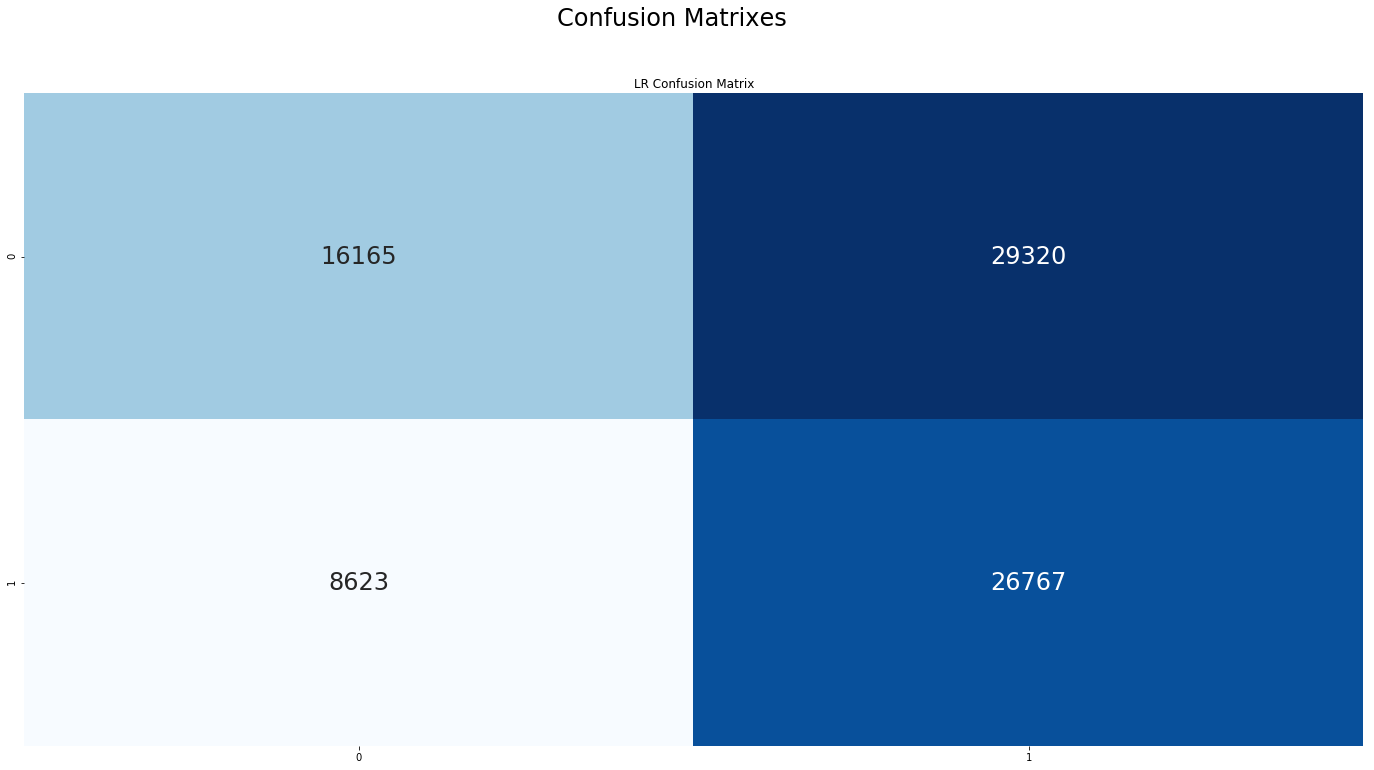

Test AUC 0.5838511664430185
('For rptcatg = ', 'Appliance Repair')


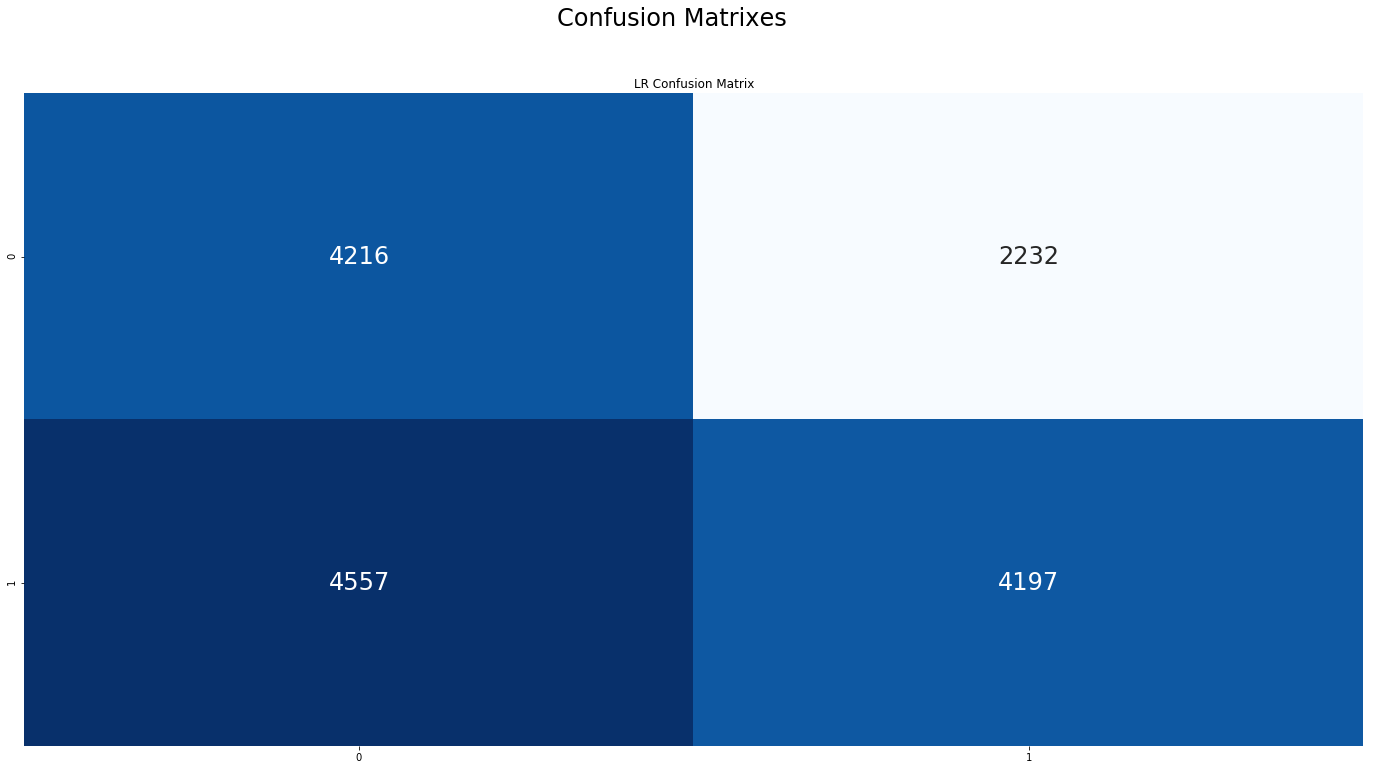

Test AUC 0.5847959139254117
('For rptcatg = ', 'Cleaning - Other')


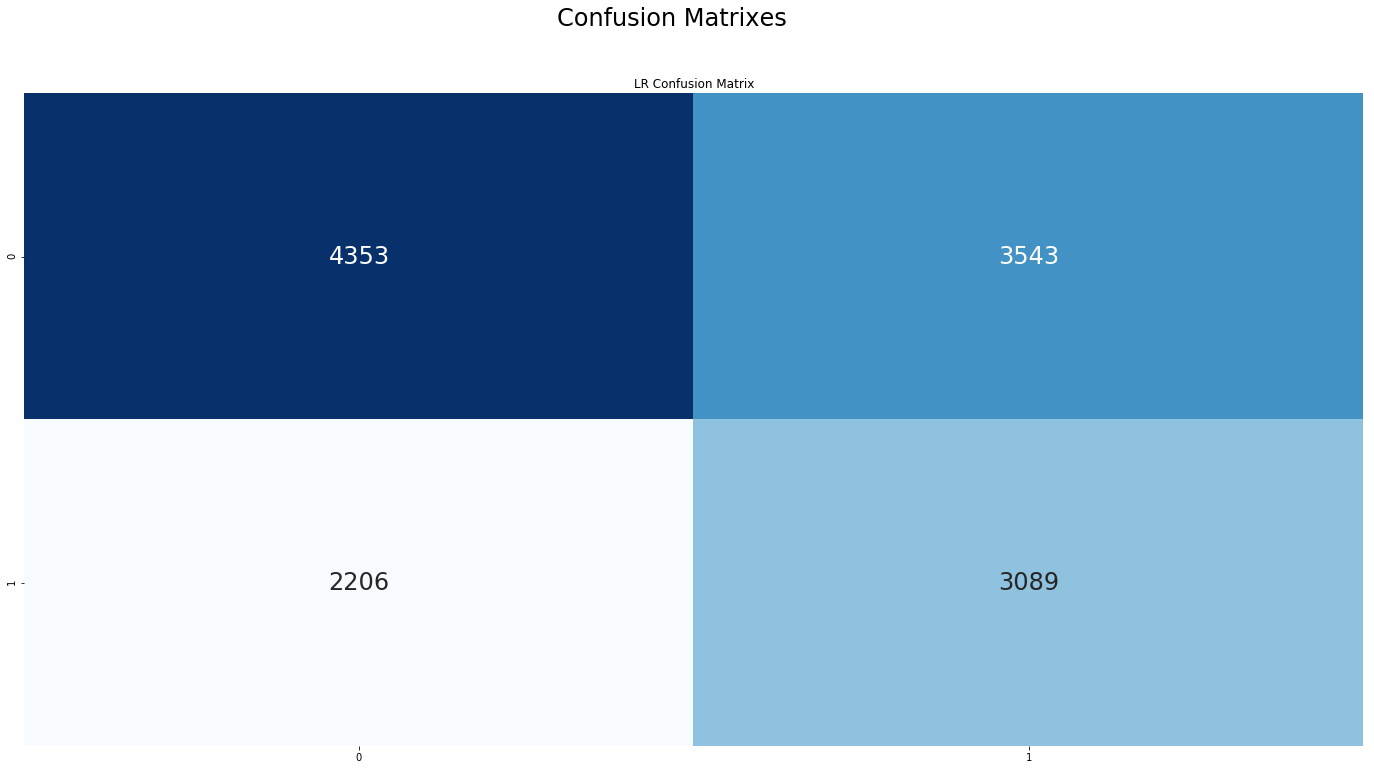

Test AUC 0.5612316366187942
('For rptcatg = ', 'EPC')


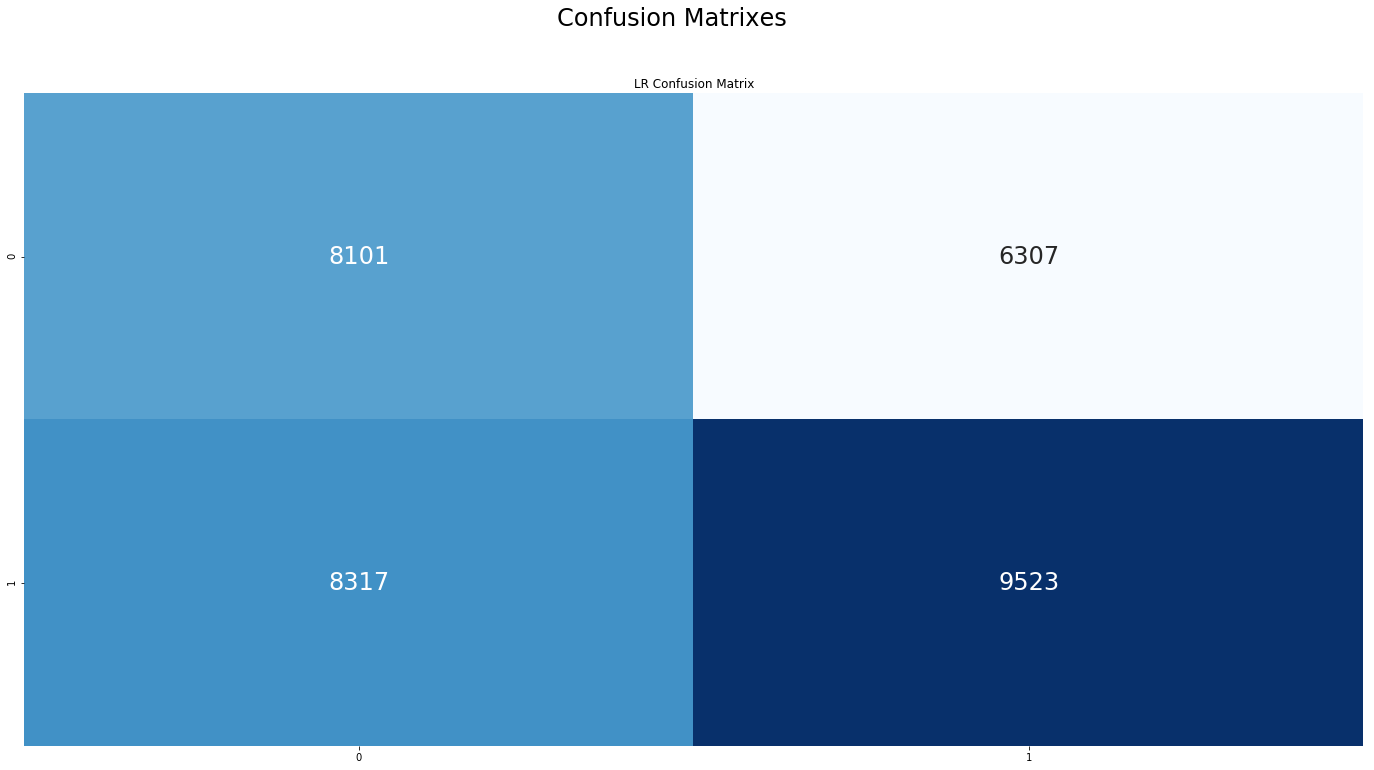

Test AUC 0.5964083102961674
('For rptcatg = ', 'Spa for Women')


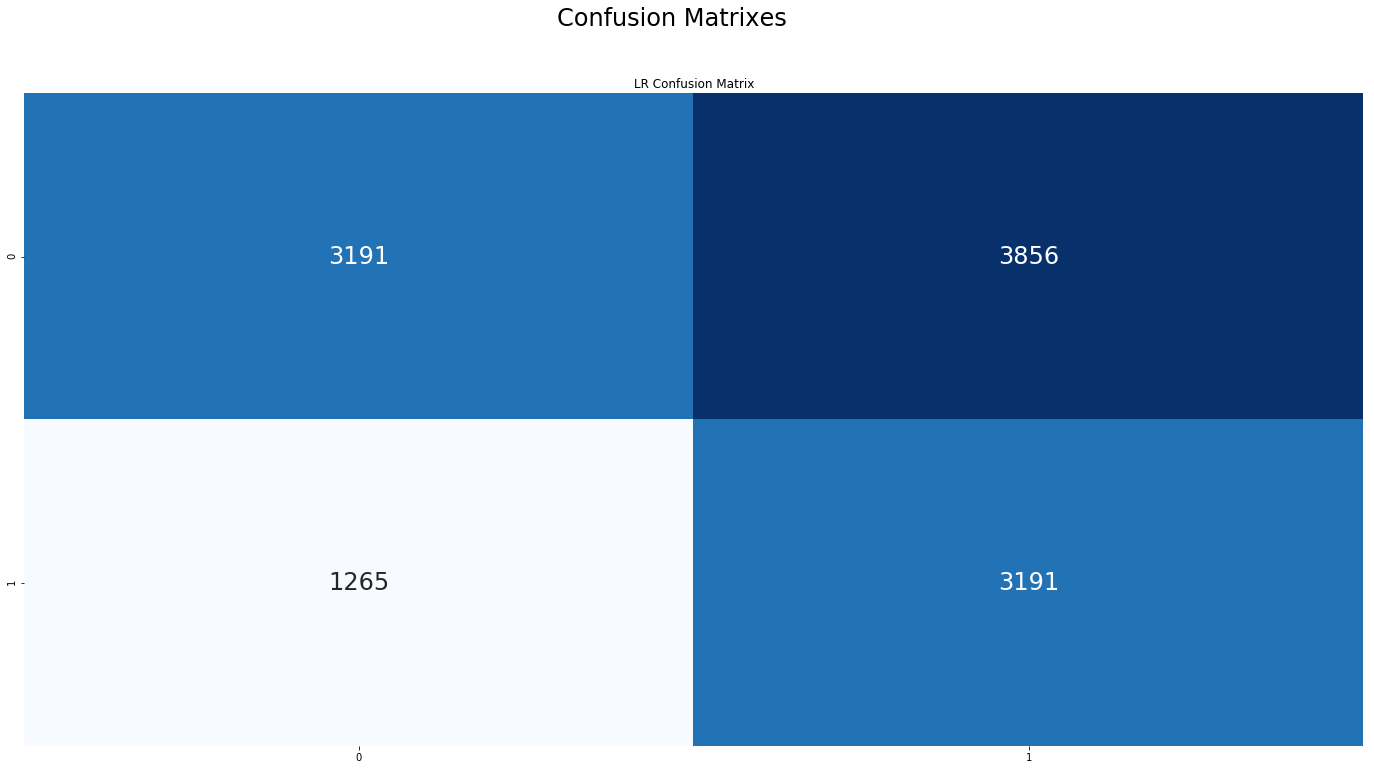

Test AUC 0.5575474681415096
('For rptcatg = ', 'Full Home Cleaning')


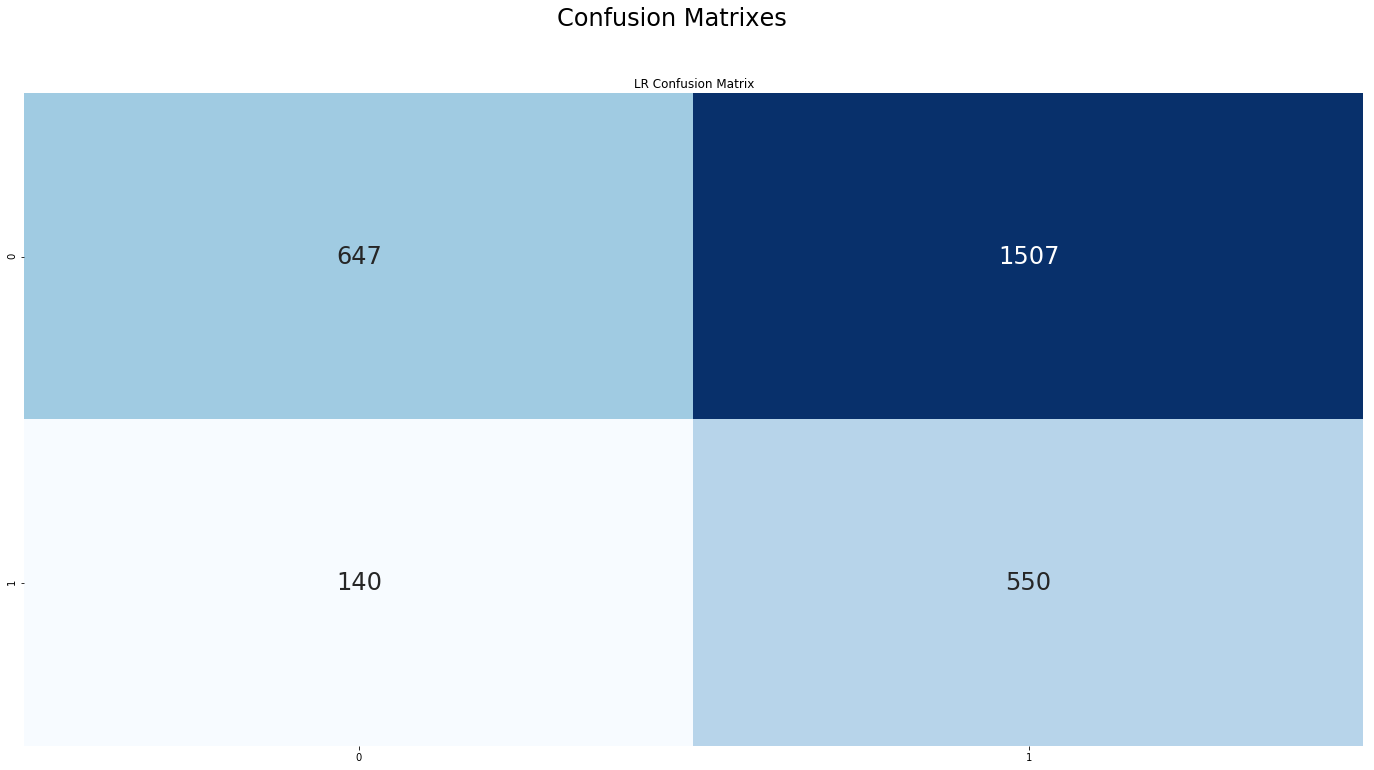

Test AUC 0.569973049315782
('For rptcatg = ', 'Massage for Men')


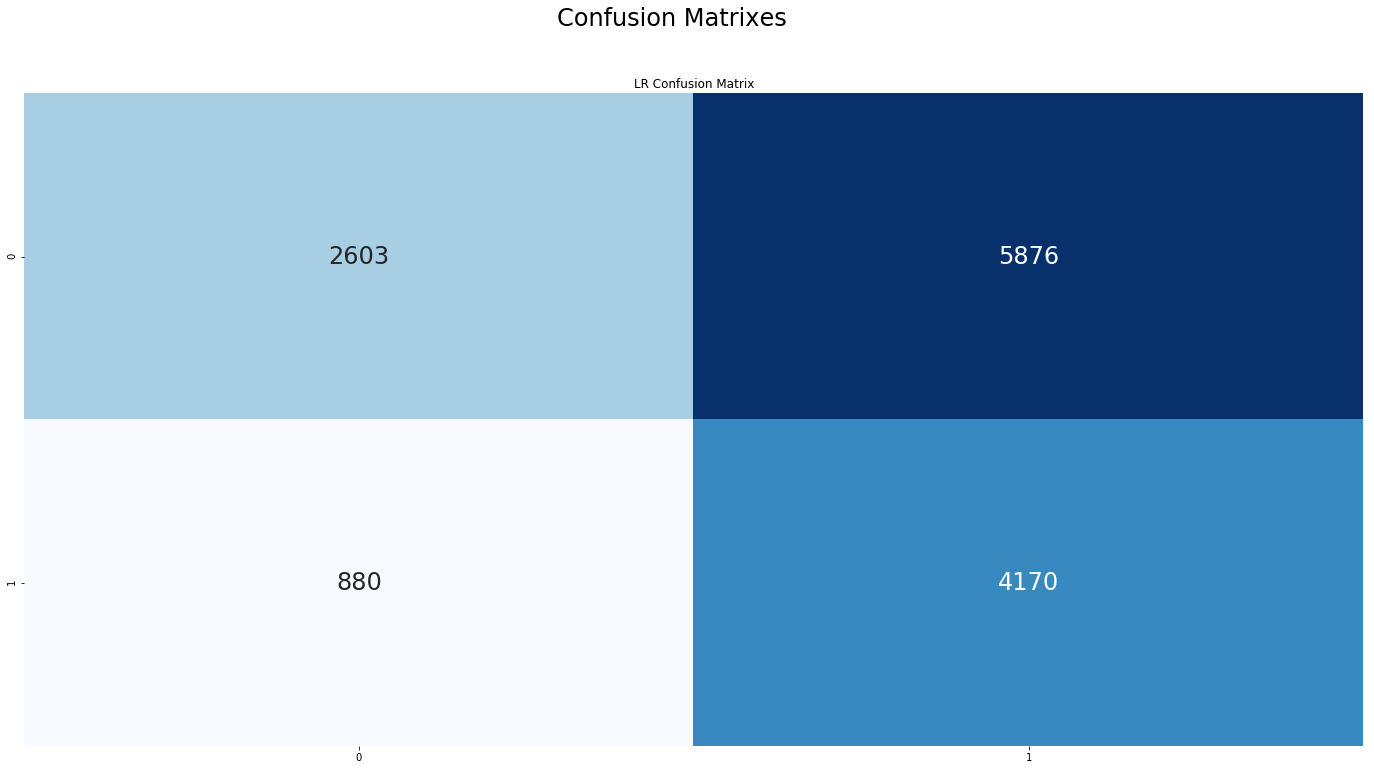

Test AUC 0.5034962712764949
('For rptcatg = ', 'Mens Grooming')


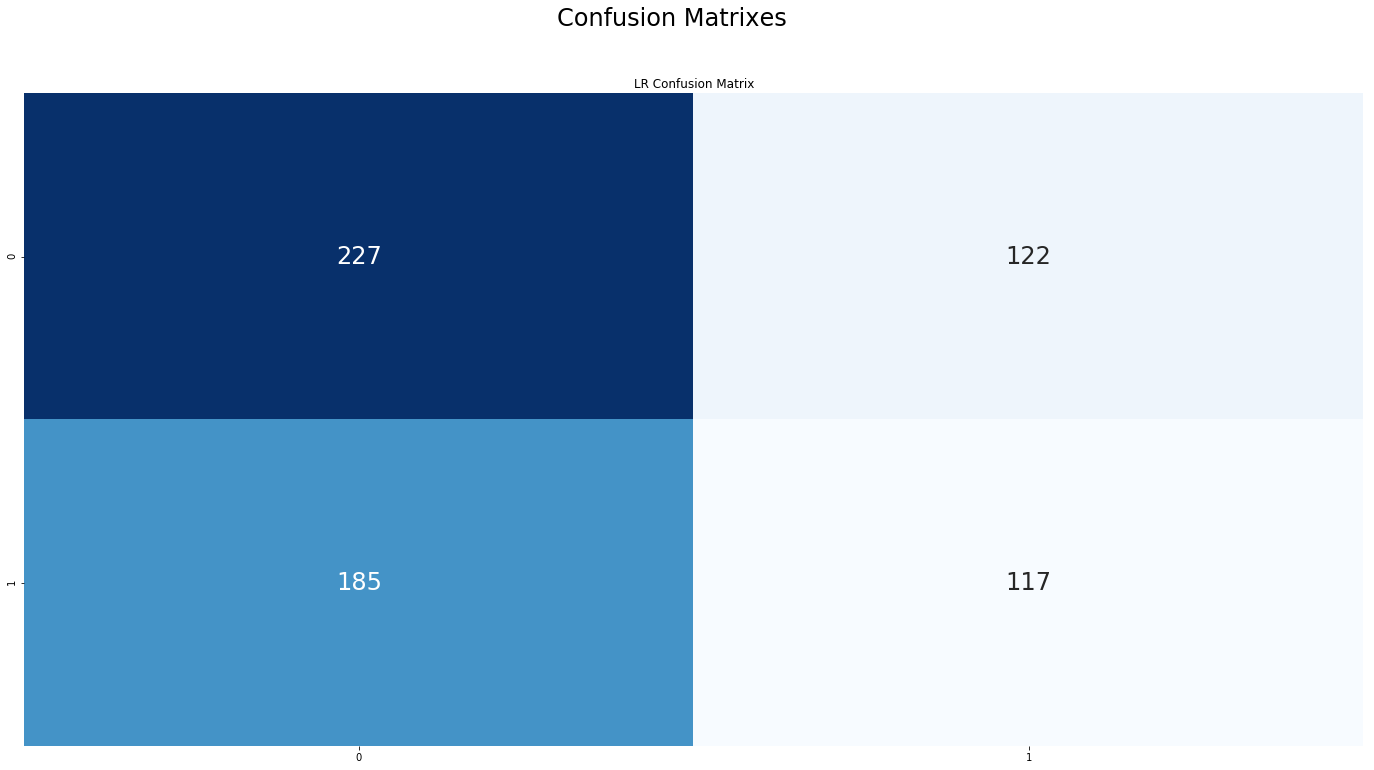

Test AUC 0.5481351560584502
('For rptcatg = ', 'Pest Control')


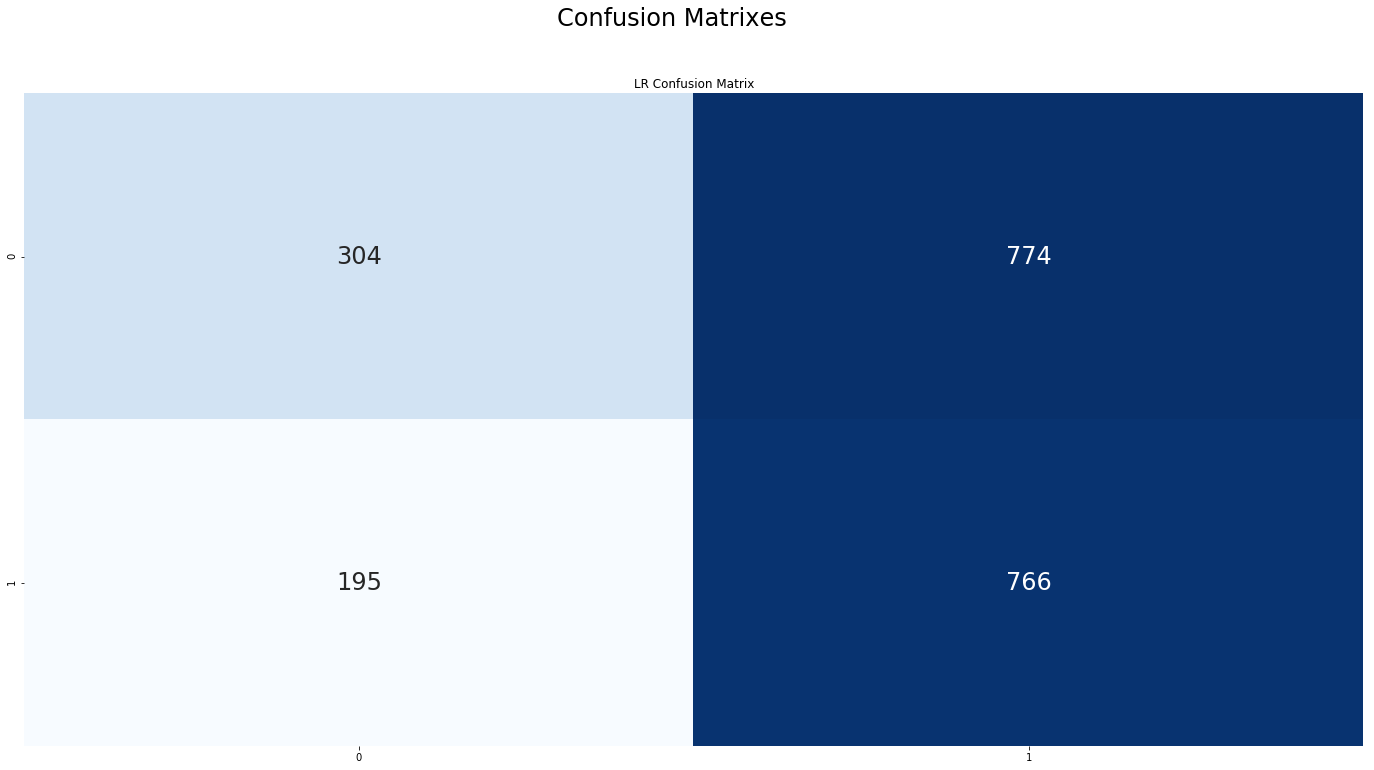

In [24]:
from sklearn.metrics import confusion_matrix
last = data__[data__["event_time"] >"2019-01-14 00:00:00"].copy()
last["finalpred"] = logisticRegr.predict_proba(X_test)[:,1]
# #false_positive_rate, true_positive_rate
# optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
# optimal_threshold = thresholds[optimal_idx]
# optimal_threshold
for ele in last['rptcatg'].unique():
    plt.figure(figsize=(24,12))
    plt.suptitle("Confusion Matrixes",fontsize=24)
    plt.subplots_adjust(wspace = 0.4, hspace= 0.4)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(last[last['rptcatg'] == ele]["Label"], last[last['rptcatg'] == ele]["finalpred"])
    optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
    optimal_threshold = thresholds[optimal_idx]

    cm_lr = confusion_matrix(last[last['rptcatg'] == ele]["Label"], last[last['rptcatg'] == ele]["finalpred"] > optimal_threshold)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(last[last['rptcatg'] == ele]["Label"], last[last['rptcatg'] == ele]["finalpred"])
    print "Test AUC",auc(false_positive_rate, true_positive_rate)

    plt.title("LR Confusion Matrix")
    print("For rptcatg = ", ele)
    sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
    plt.show()

## Ensemble Technique

In [25]:
%%time
pred1=clf.predict_proba(X_train)
pred2=logisticRegr.predict_proba(X_train)
weigh_rf = 0.5
finalpred=(weigh_rf*pred1+(1-weigh_rf)*pred2)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, finalpred[:,1])
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, finalpred)
print "Train AUC",auc(false_positive_rate, true_positive_rate)


pred1=clf.predict_proba(X_test)
pred2=logisticRegr.predict_proba(X_test)
finalpred=(weigh_rf*pred1+(1-weigh_rf)*pred2)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, finalpred[:,1])
#false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, finalpred)
print "Test AUC",auc(false_positive_rate, true_positive_rate)


Train AUC 0.6235570949848314
Test AUC 0.6071641771002181
CPU times: user 5.44 s, sys: 8.23 s, total: 13.7 s
Wall time: 6.46 s


Test AUC 0.5813194069270001
('For rptcatg = ', 'Salon at Home')


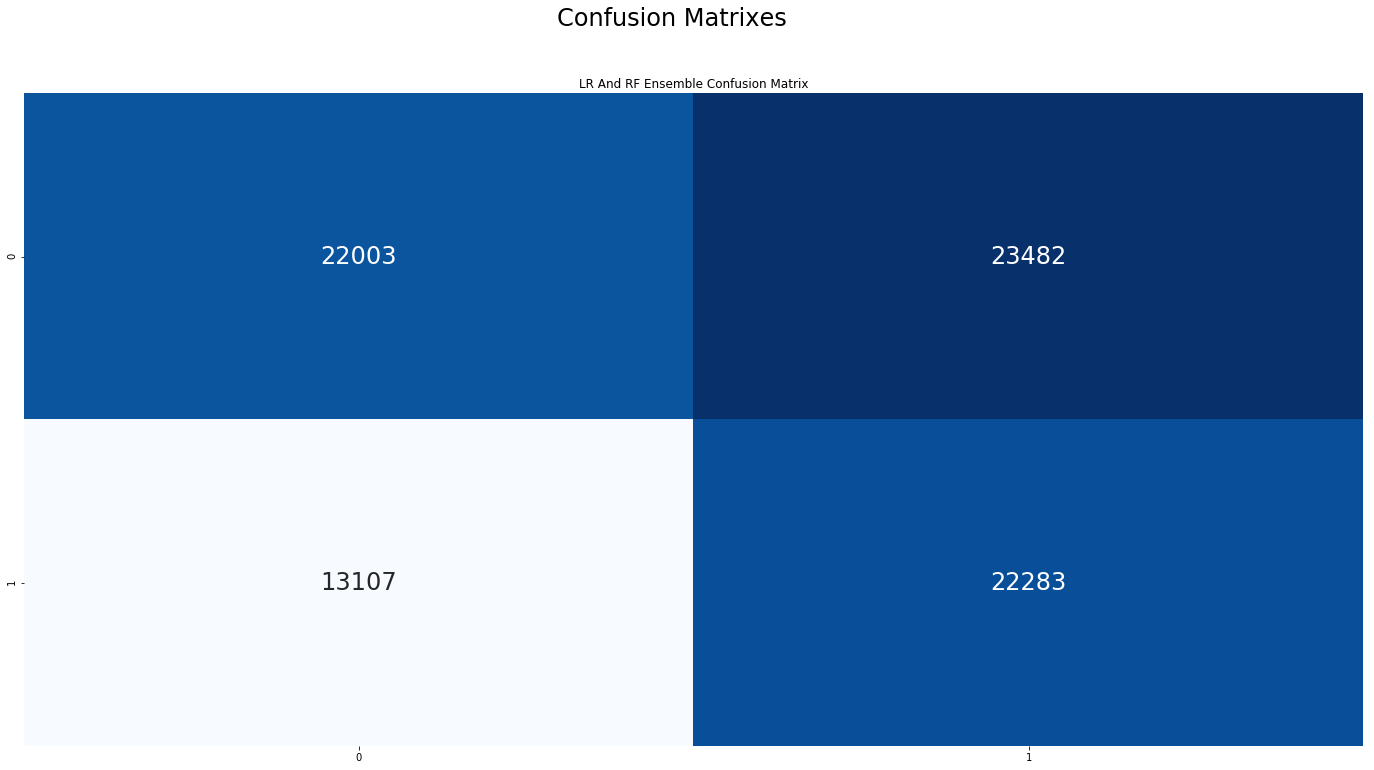

Test AUC 0.5838630716706039
('For rptcatg = ', 'Appliance Repair')


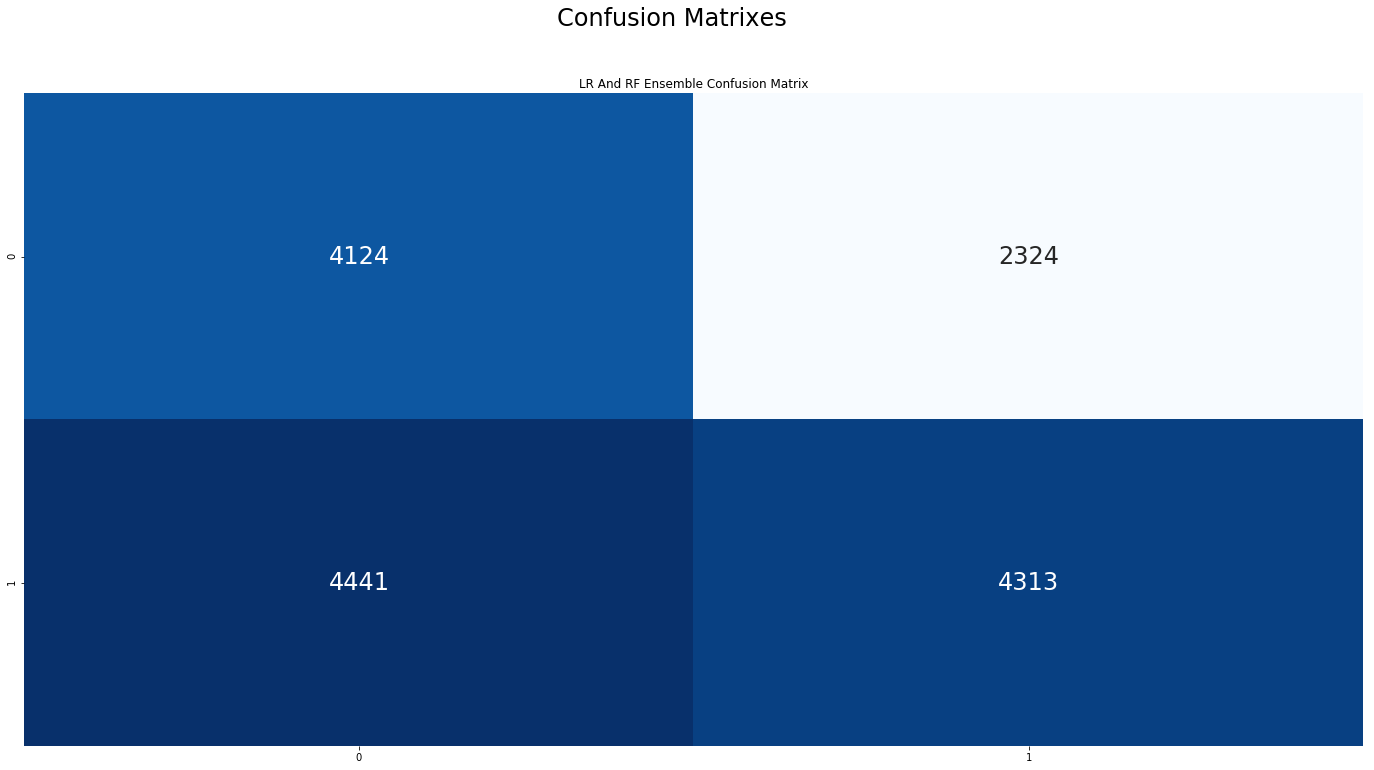

Test AUC 0.5853042694786712
('For rptcatg = ', 'Cleaning - Other')


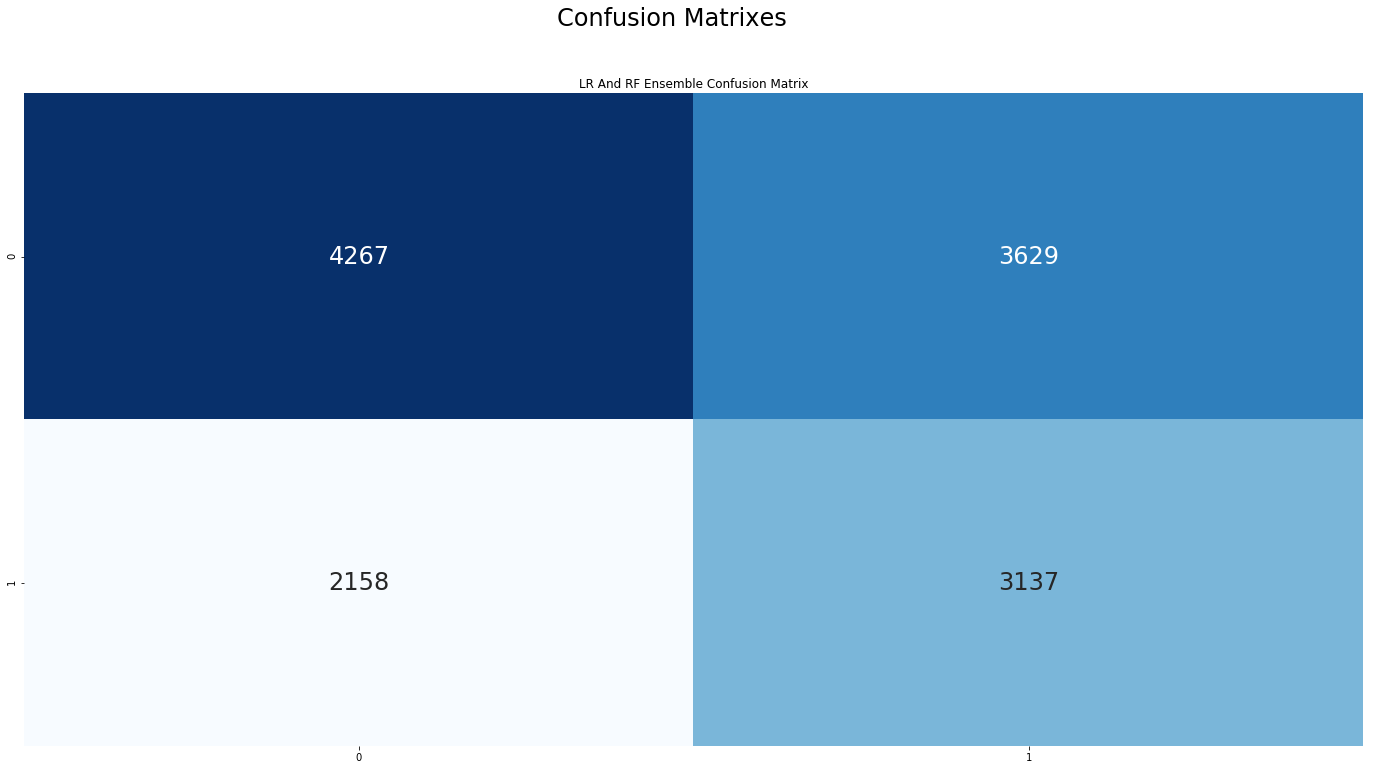

Test AUC 0.5683665460985801
('For rptcatg = ', 'EPC')


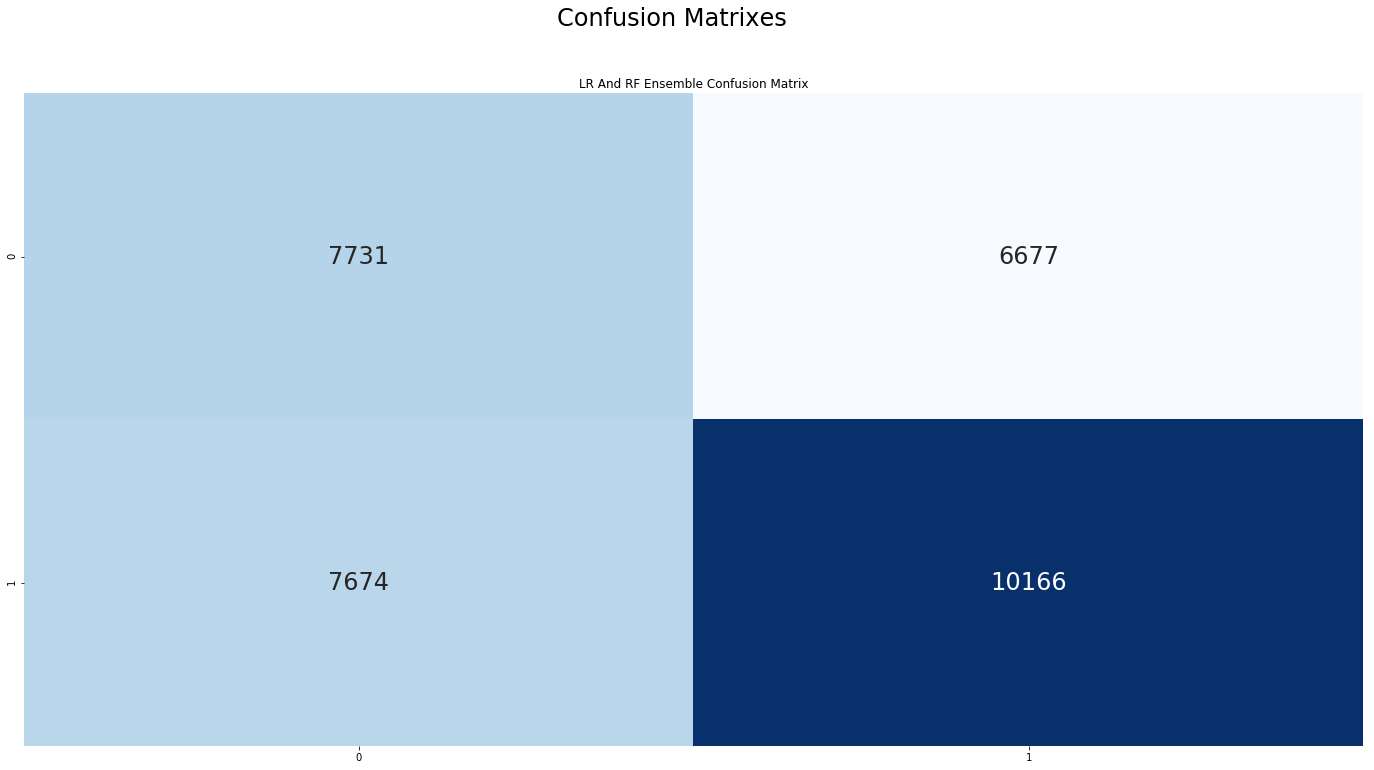

Test AUC 0.5985729568001867
('For rptcatg = ', 'Spa for Women')


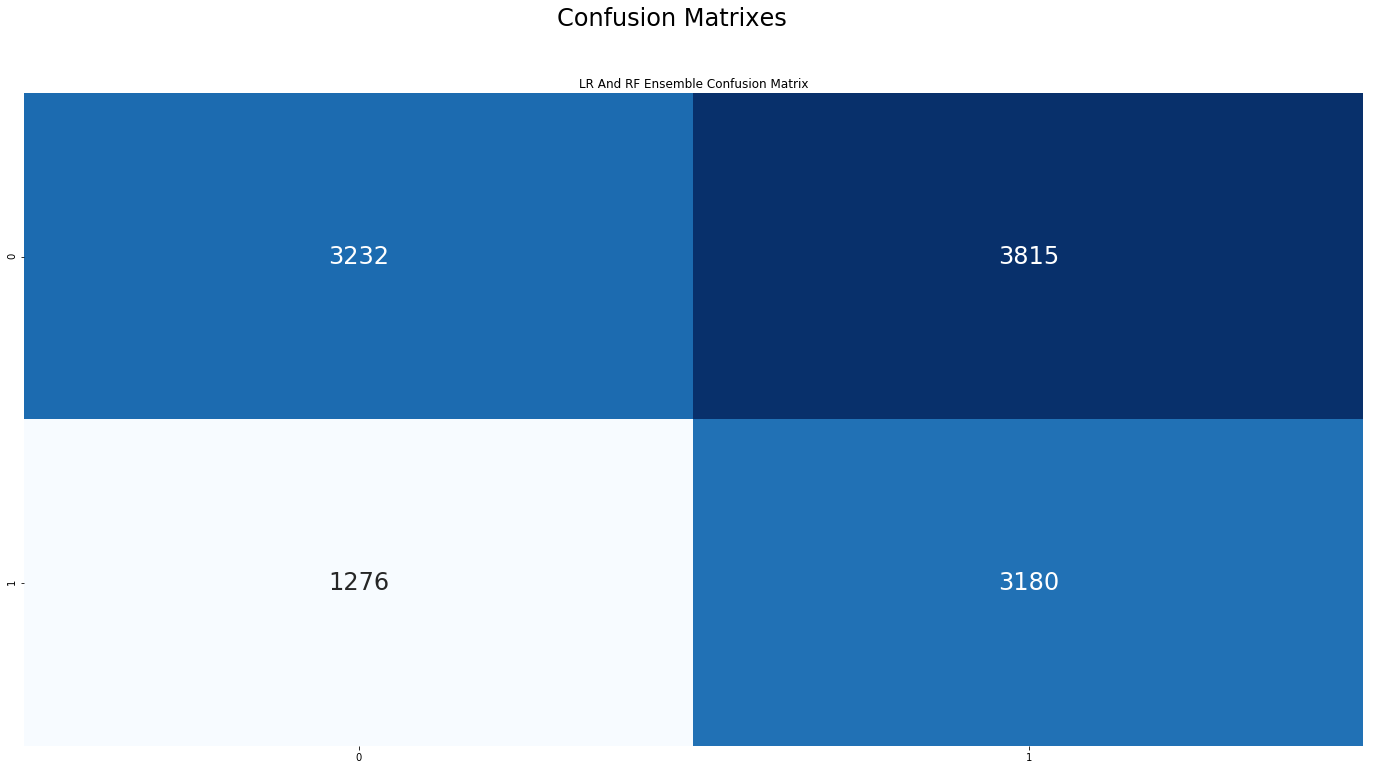

Test AUC 0.5379163134310281
('For rptcatg = ', 'Full Home Cleaning')


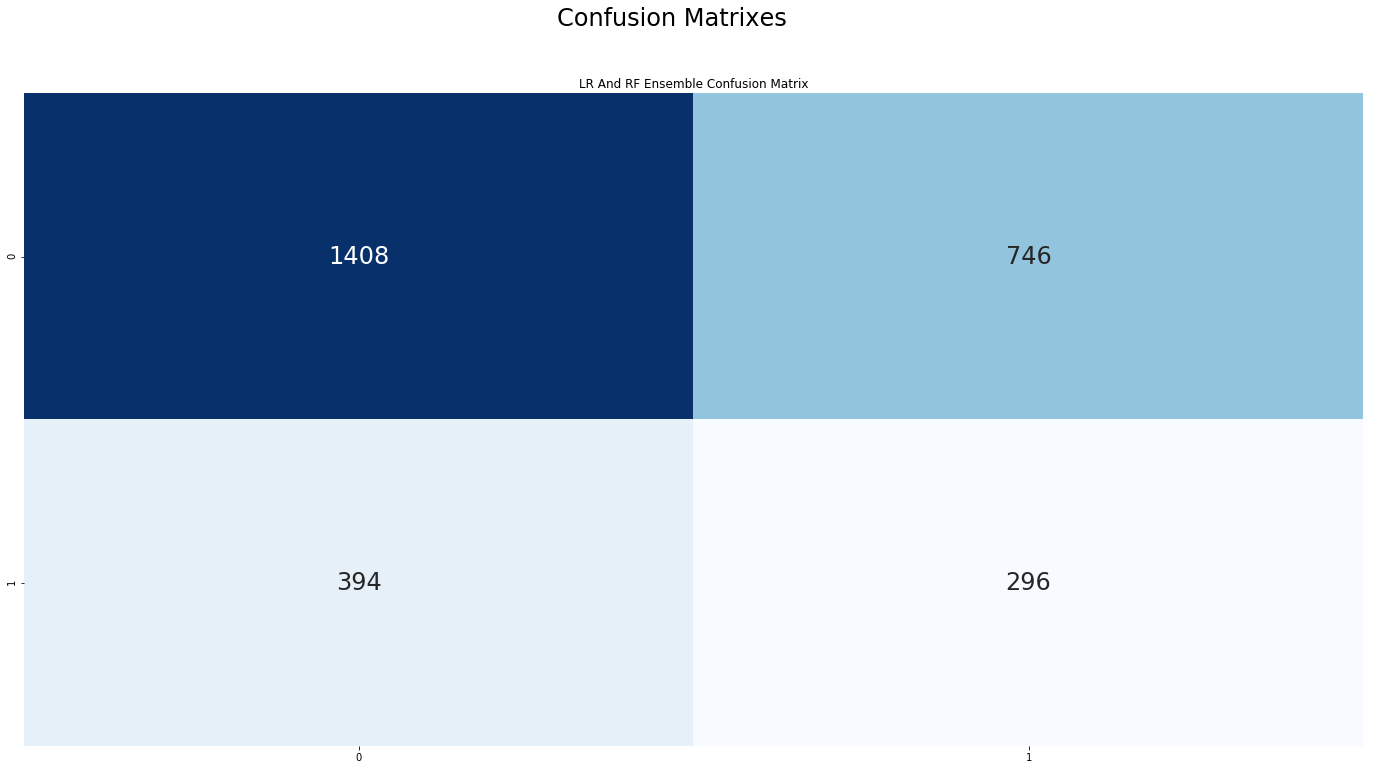

Test AUC 0.5706201226326194
('For rptcatg = ', 'Massage for Men')


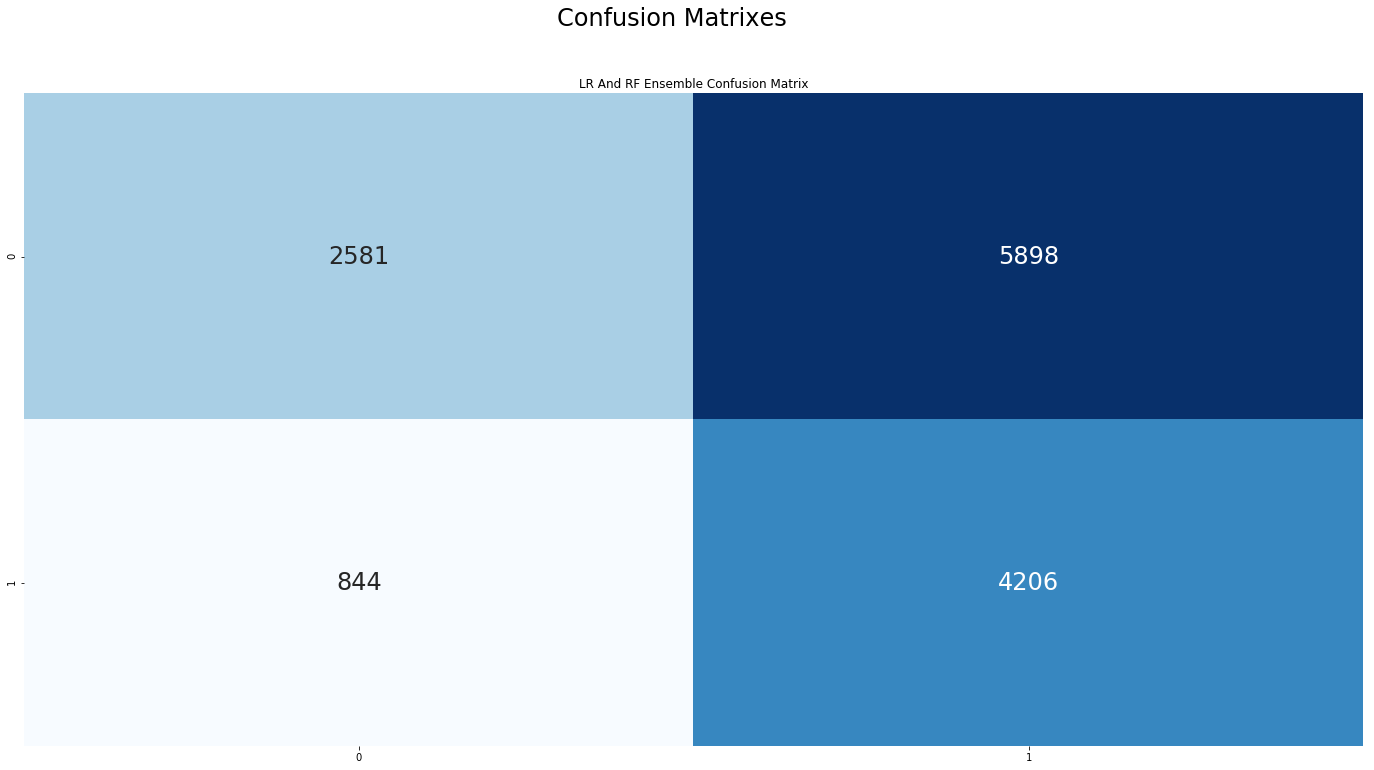

Test AUC 0.5134679974952087
('For rptcatg = ', 'Mens Grooming')


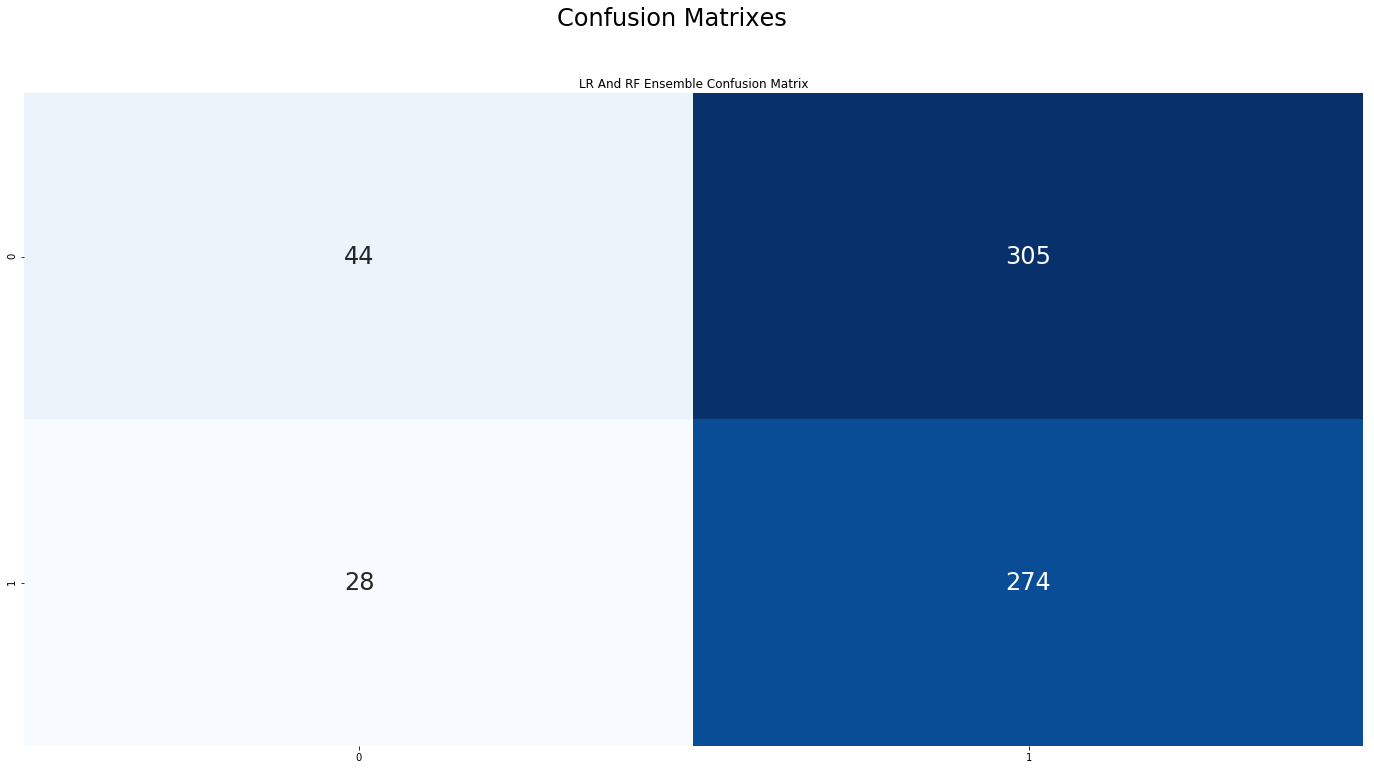

Test AUC 0.548372617422714
('For rptcatg = ', 'Pest Control')


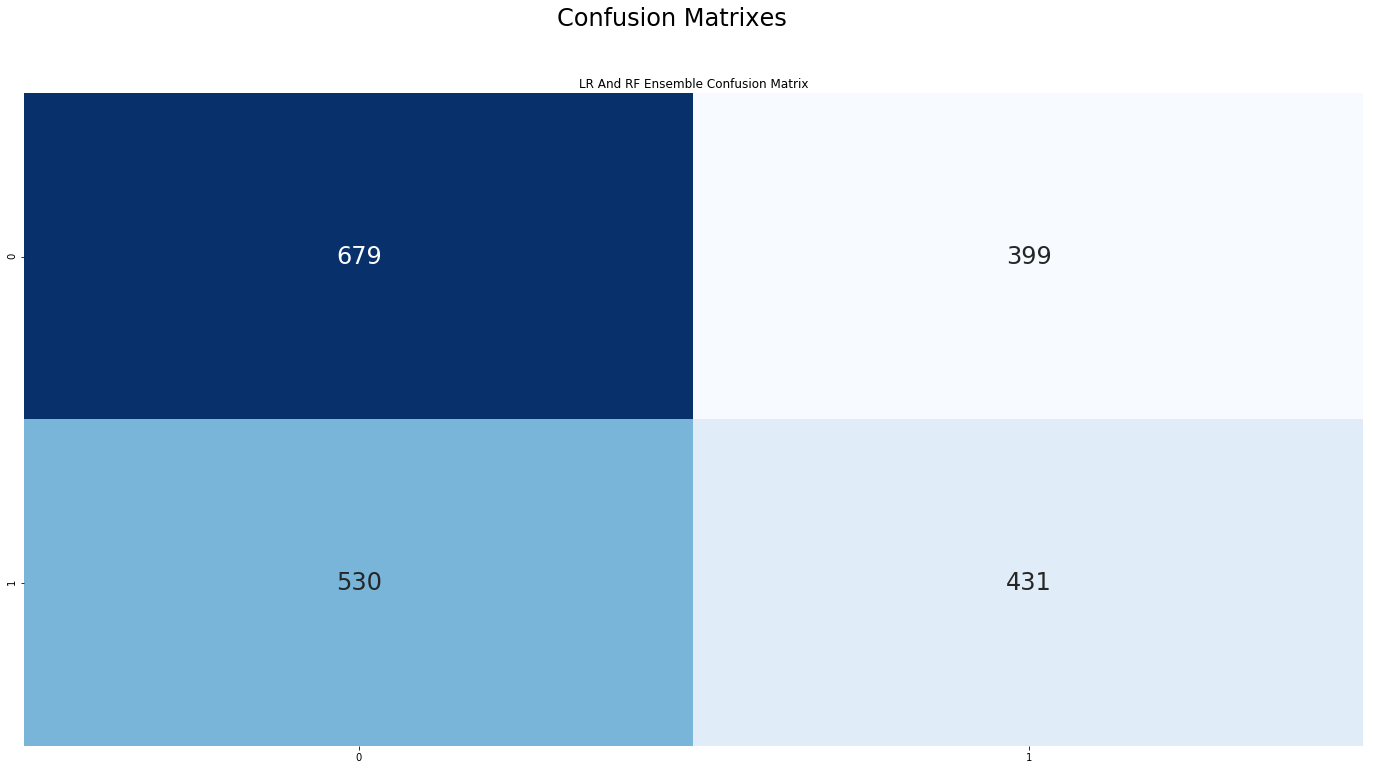

In [26]:
from sklearn.metrics import confusion_matrix
last = data__[data__["event_time"] >"2019-01-14 00:00:00"].copy()
last["finalpred"] = finalpred[:,1]
# #false_positive_rate, true_positive_rate
# optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
# optimal_threshold = thresholds[optimal_idx]
# optimal_threshold
for ele in last['rptcatg'].unique():
    plt.figure(figsize=(24,12))
    plt.suptitle("Confusion Matrixes",fontsize=24)
    plt.subplots_adjust(wspace = 0.4, hspace= 0.4)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(last[last['rptcatg'] == ele]["Label"], last[last['rptcatg'] == ele]["finalpred"])
    optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
    optimal_threshold = thresholds[optimal_idx]

    cm_lr = confusion_matrix(last[last['rptcatg'] == ele]["Label"], last[last['rptcatg'] == ele]["finalpred"] > optimal_threshold)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(last[last['rptcatg'] == ele]["Label"], last[last['rptcatg'] == ele]["finalpred"])
    print "Test AUC",auc(false_positive_rate, true_positive_rate)

    plt.title("LR And RF Ensemble Confusion Matrix")
    print("For rptcatg = ", ele)
    sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})
    plt.show()

## Predicted Probability Distribution 

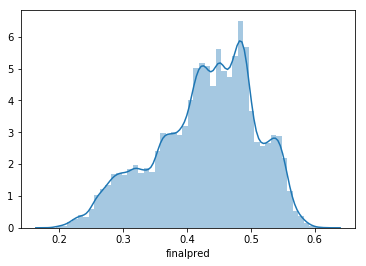

In [27]:
sns.distplot(last["finalpred"])

## ROC-AUC, PRC-AUC, and Confusion Matrix for Ensemble Model

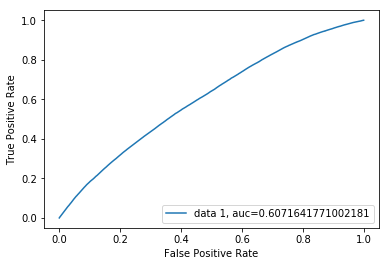

In [28]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(last["Label"], last["finalpred"])
auc = metrics.roc_auc_score(last["Label"], last["finalpred"])
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

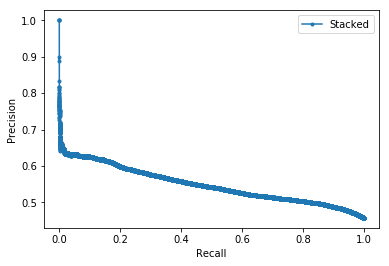

In [29]:
from matplotlib import pyplot
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
lr_precision, lr_recall, _ = precision_recall_curve(y_test, finalpred[:,1])
#ns_fpr, ns_tpr, _ = precision_recall_curve(y_test, finalpred[:,1])
pyplot.plot(lr_recall, lr_precision, marker='.', label='Stacked')
plt.xlabel('Recall')
plt.ylabel('Precision')
pyplot.legend()
pyplot.show()

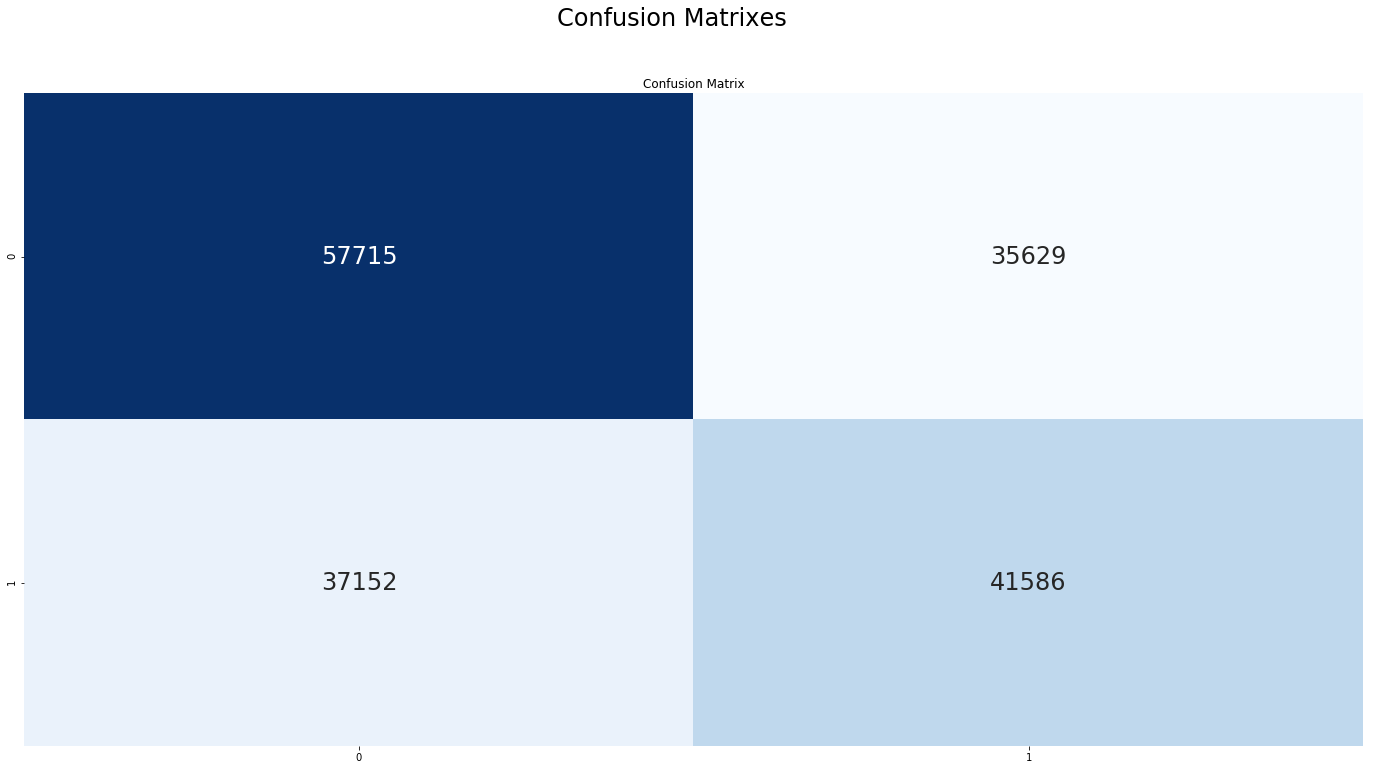

In [30]:
plt.figure(figsize=(24,12))

plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

#plt.subplot(2,3,1)
from sklearn.metrics import confusion_matrix

cm_lr = confusion_matrix(y_test, finalpred[:,1]>optimal_threshold)
plt.title("Confusion Matrix")
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

In [31]:
save_for_last = finalpred[:,1]

## Test Case 1

In [48]:
from sklearn.metrics import confusion_matrix
last = data__[data__["event_time"] >"2019-01-14 00:00:00"].copy()
last["finalpred"] = save_for_last
# #false_positive_rate, true_positive_rate
# optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
# optimal_threshold = thresholds[optimal_idx]
# optimal_threshold
false_positive_rate, true_positive_rate, thresholds = roc_curve(last["Label"], last["finalpred"])
optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
optimal_threshold = thresholds[optimal_idx]
# 
dd_ = pd.DataFrame(data__[data__["event_time"] >"2019-01-14 00:00:00"]['rptcatg'].value_counts(normalize=True))
for ele,val in zip(dd_.index,dd_.values):
#     false_positive_rate, true_positive_rate, thresholds = roc_curve(last[last['rptcatg'] == ele]["Label"], last[last['rptcatg'] == ele]["finalpred"])
#     optimal_idx = np.argmax(true_positive_rate - false_positive_rate)
#     optimal_threshold = thresholds[optimal_idx]
    print("rptcatg name and normalised count = ",ele , val)
    #print("True Distribution for :", ele)
    aa =  pd.DataFrame(last[last['rptcatg'] == ele]["Label"].value_counts())
    last["finalpred_hard"] = (last[last['rptcatg'] == ele]["finalpred"] > optimal_threshold).astype(int)
    #print("Predicted Distribution for :", ele)
    bb = pd.DataFrame(last[last['rptcatg'] == ele]["finalpred_hard"].value_counts())
    dd = aa.join(bb)
    dd = dd.reset_index()
    dd.columns = ["True_Label", "Count of Label", "Count of Predicted Label"]
    dd.fillna(0,inplace=True)
    #print("##########")
    print dd

('rptcatg name and normalised count = ', 'Salon at Home', array([0.46997943]))
   True_Label  Count of Label  Count of Predicted Label
0           0           45485                     44221
1           1           35390                     36654
('rptcatg name and normalised count = ', 'EPC', array([0.18739903]))
   True_Label  Count of Label  Count of Predicted Label
0           1           17840                     30201
1           0           14408                      2047
('rptcatg name and normalised count = ', 'Appliance Repair', array([0.0883416]))
   True_Label  Count of Label  Count of Predicted Label
0           1            8754                      8167
1           0            6448                      7035
('rptcatg name and normalised count = ', 'Massage for Men', array([0.0786195]))
   True_Label  Count of Label  Count of Predicted Label
0           0            8479                   13529.0
1           1            5050                       0.0
('rptcatg name and 

## Test Case 2

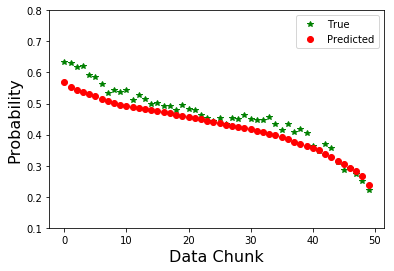

In [75]:
last = last.sort_values('finalpred',ascending = False)
df_split = np.array_split(last, 50)
a_label = []
a_final_pred = []
for df in df_split:
    a_label.append(df['Label'].mean())
    a_final_pred.append(df["finalpred"].mean())
    #print(df['Label'].mean(),df["finalpred"].mean())
    
import matplotlib.pyplot as plt
plt.plot(a_label,'g*',label="True")
plt.plot(a_final_pred, 'ro',label="Predicted")
plt.legend(loc="upper right")
plt.ylim(0.1, 0.8)
plt.xlabel('Data Chunk', fontsize=16)
plt.ylabel('Probability', fontsize=16)
plt.show()
